In [2]:
import os
import joblib
import pandas as pd
import numpy as np
import pingouin as pg
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix    #导入计算混淆矩阵的包
import warnings
warnings.filterwarnings("ignore")

### Introduction
+ For code modularity, each section begin with read data from file and end with out data into files.
+ Each code section can be executed independently if the input files exist.

In [3]:
cwd = os.getcwd()
traindir = 'Feas_data'
datadir = os.path.join(cwd, traindir)
imgdir = os.path.join(cwd, 'IMG')
# pdf = os.path.join(datadir, 'pos_scalefeas2.csv')
# ndf = os.path.join(datadir, 'neg_scalefeas2.csv')
modeldir = os.path.join(cwd, 'Model')
imgdir = os.path.join(cwd, 'IMG')
# idf = os.path.join(cwd)
# pdf = pd.read_csv(pdf)
# ndf = pd.read_csv(ndf)
all_info_columns = ['pid', 'label', 'series', 'RD', 'mask', 'dataset', 'image']
tag_cols = ['pid', 'label', 'series', 'image', 'mask']
tag_cols1 = ['pid', 'label']
sequence_id = [2, 3, 4]
random_state = 2022
all_data = pd.read_csv('../DataPreprocess/dataset_info/data_train_test.csv')
all_train = all_data[all_data['dataset']=='train']
all_train.head()
all_train.sort_values(['pid']).head(15)

pid     pid1  label  RD img_type  \
0      1  1307903      0  R0    dicom   
1      1  1307903      0  R0      nii   
2      1  1307903      0  R0      nii   
263    2  1308524      1  R2      nii   
262    2  1308524      1  R2      nii   
261    2  1308524      1  R2    dicom   
165    3  1316577      1  R1    dicom   
166    3  1316577      1  R1      nii   
167    3  1316577      1  R1    dicom   
68     4  1318995      0  R0      nii   
67     4  1318995      0  R0      nii   
66     4  1318995      0  R0    dicom   
193    5  1321482      1  R1      nii   
194    5  1321482      1  R1      nii   
192    5  1321482      1  R1    dicom   

                                                 image  \
0    /media/tx-deepocean/Data/2022/chongfu1/Dataset...   
1    /media/tx-deepocean/Data/2022/chongfu1/Dataset...   
2    /media/tx-deepocean/Data/2022/chongfu1/Dataset...   
263  /media/tx-deepocean/Data/2022/chongfu1/Dataset...   
262  /media/tx-deepocean/Data/2022/chongfu1/Dataset...   
261  /media/tx-deepocean/Data/2022/chongfu1/Dataset...   
165  /media/tx-deepocean/Data/2022/chongfu1/Dataset...   
166  /media/tx-deepocean/Data/2022/chongfu1/Dataset...   
167  /media/tx-deepocean/Data/2022/chongfu1/Dataset...   
68   /media/tx-deepocean/Data/2022/chongfu1/Dataset...   
67   /media/tx-deepocean/Data/2022/chongfu1/Dataset...   
66   /media/tx-deepocean/Data/2022/chongfu1/Dataset...   
193  /media/tx-deepocean/Data/2022/chongfu1/Dataset...   
194  /media/tx-deepocean/Data/2022/chongfu1/Dataset...   
192  /media/tx-deepocean/Data/2022/chongfu1/Dataset...   

                                                  mask  series  \
0    /media/tx-deepocean/Data/2022/chongfu1/Dataset...       2   
1    /media/tx-deepocean/Data/2022/chongfu1/Dataset...       3   
2    /media/tx-deepocean/Data/2022/chongfu1/Dataset...       4   
263  /media/tx-deepocean/Data/2022/chongfu1/Dataset...       4   
262  /media/tx-deepocean/Data/2022/chongfu1/Dataset...       3   
261  /media/tx-deepocean/Data/2022/chongfu1/Dataset...       2   
165  /media/tx-deepocean/Data/2022/chongfu1/Dataset...       2   
166  /media/tx-deepocean/Data/2022/chongfu1/Dataset...       3   
167  /media/tx-deepocean/Data/2022/chongfu1/Dataset...       4   
68   /media/tx-deepocean/Data/2022/chongfu1/Dataset...       4   
67   /media/tx-deepocean/Data/2022/chongfu1/Dataset...       3   
66   /media/tx-deepocean/Data/2022/chongfu1/Dataset...       2   
193  /media/tx-deepocean/Data/2022/chongfu1/Dataset...       3   
194  /media/tx-deepocean/Data/2022/chongfu1/Dataset...       4   
192  /media/tx-deepocean/Data/2022/chongfu1/Dataset...       2   

          image_size        mask_size  size_consis dataset  
0     (512, 512, 26)   (512, 512, 26)         True   train  
1     (256, 256, 26)   (256, 256, 26)         True   train  
2    (512, 512, 168)  (512, 512, 168)         True   train  
263   (512, 512, 92)   (512, 512, 92)         True   train  
262   (256, 256, 22)   (256, 256, 22)         True   train  
261   (512, 512, 22)   (512, 512, 22)         True   train  
165   (512, 512, 30)   (512, 512, 30)         True   train  
166   (256, 256, 28)   (256, 256, 28)         True   train  
167   (512, 512, 96)   (512, 512, 96)         True   train  
68    (512, 512, 96)   (512, 512, 96)         True   train  
67    (256, 256, 26)   (256, 256, 26)         True   train  
66    (512, 512, 26)   (512, 512, 26)         True   train  
193   (256, 256, 29)   (256, 256, 29)         True   train  
194  (512, 512, 200)  (512, 512, 200)         True   train  
192   (512, 512, 29)   (512, 512, 29)         True   train

## Function definition 

In [4]:
def wprint(info, style=0):
    '''
    :description: Information print with separator.
    :param info: 'str', The information which want to print. 
    :param style: 'int', 0: Only one line info.
    '''
    if len(info) < 57:
        tot_len = 60
    elif len(info) < 77:
        tot_len = 80
    else:
        tot_len = len(info)+6
    space_len = (tot_len - len(info) - 6) // 2
    print('='*tot_len)
    print('=',' '*space_len, f'\033[1;97;95m{info}\033[0m', ' '*(tot_len-space_len-6-len(info)),'=')
    print('='*tot_len)
    
def append_csv(csv_files, save_file, del_csv=False):
    '''
    :description: Merge multi csv files in axis=0.
    :param csv_files: Paths of the batch csv files. All the files have the same columns.
    :param save_file: File to store the data after merging.
    :param del_csv:   Delete the `csv_files` if del_csv=True.
    :return: True: If successed merged; False: If files in csv_files not exist.
    '''
    # If file_ in csv_files not exist, return False.
    for file_ in csv_files:
        if not os.path.exists(file_):
            return False
    header = True    # Choose the first csv header to be the merged header.
    if os.path.exists(save_file):
        os.remove(save_file)
    for file_ in csv_files:
        if '.csv' in file_:
            data = pd.read_csv(file_)
            data.to_csv(save_file, mode='a', header = header, index=0) 
        if header:
            header = False
    if del_csv:
        for file_ in csv_files:
            os.remove(file_)
    return True

def data_cleaning(df):
    '''
    :description: Cleaning the nan data.
    :param df: 'Dataframe': Input dataframe with raw data.
    :return: 'Dataframe': Non-nan exist.
    '''
    # add a line to delete col with number(nan)>half(len)
    df = df.fillna(df.median())
    return df

def icc_scores(df1, df2, rater='reader', target='target'):
    df = pd.concat([df1, df2], axis=0)
    score_df = pd.DataFrame(columns=['ICC1', 'ICC2', 'ICC3', 'ICC1k', 'ICC2k', 'ICC3k'])
    for col in df.columns[2:]:
        icc = pg.intraclass_corr(data=df, targets=target, raters=rater, ratings=col)['ICC']
        score_df.loc[col] = list(icc)
    return score_df

# According to the index('str'), to select the df1[add_list] to concate with df.
def df_added(df, df1, index, add_cols, how='inner'):
    cols_copy = add_cols.copy()
    cols_copy.insert(0, index)
    new_df1 = df1[cols_copy]
    new_df = pd.merge(new_df1, df, on=index, how=how)  # 'inner' 表示只取交集
    return new_df

def calcu_evaluation(true_label, predict):
    C = confusion_matrix(true_label, predict)
    TP = C[1,1]
    FP = C[0,1]
    TN = C[0,0]
    FN = C[1,0]
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    return sensitivity, specificity, accuracy

In [5]:
wprint('1454 extracted features')

=                 1454 extracted features                  =


### (1) Merge the dataframes
+ Read the dataframes that extracted from different files.
+ Merge the dataframes 
+ Delete original files
+ Create new file for the merged dataframe

In [221]:
# Input files.
all_feas_original = pd.read_csv('../DataPreprocess/dataset_info/data_feas_original.csv')
icc_feas_original  = pd.read_csv('../DataPreprocess/dataset_info/icc_feas_original.csv')
all_feas_original = all_feas_original.sort_values(['pid','series'], ascending=[True, True])
# icc_feas_original = icc_feas_original.sort_values(['pid','series'], ascending=[True, True])

info = f'{all_feas_original.shape[0]//3} patients'
info1 = f'{all_feas_original.shape[1]-len(all_info_columns)} extracted features'
info2 = f'{icc_feas_original.shape[0]//3} patients for repeatability test'
wprint(info)
wprint(info1)
wprint(info2)

=                       228 patients                       =
=                 1454 extracted features                  =
=            50 patients for repeatability test            =


### (2) ICC selection of original features

In [222]:
# ---------------------------------------Data Cleaning and ICC selection----------------------------------------
# Files to storage the ICC filtered data.
print('*'*40,'Starting evaluating the consistence between two icc data.','*'*40)
icc_info = pd.read_csv('../DataPreprocess/dataset_info/icc_data_info.csv')

# Get the info from info_data files to pair train and icc-validation data.
icc_feas_original1 = df_added(icc_feas_original, icc_info, index='mask', add_cols=['pid', 'label', 'series'])

# From train data select the data which used to compare with ICC data
pid_list = list(icc_feas_original1['pid'].value_counts().index)
# Select the data from train data that located in icc data.
all_feas_original1 = all_feas_original[all_feas_original['pid'].isin(pid_list)]
print(len(all_feas_original1))
print(len(icc_feas_original1))

**************************************** Starting evaluating the consistence between two icc data. ****************************************
150
150


In [223]:
# Feature cleaning
all_feas_original1 = data_cleaning(all_feas_original1)
icc_feas_original1 = data_cleaning(icc_feas_original1)
all_feas_original1 = all_feas_original1.sort_values(['pid', 'series'], ascending=[True, True])
icc_feas_original1 = icc_feas_original1.sort_values(['pid', 'series'], ascending=[True, True])
all_feas_original2 = all_feas_original1.drop(all_info_columns, axis=1, errors='ignore')
icc_feas_original2 = icc_feas_original1.drop(all_info_columns, axis=1, errors='ignore')
all_feas_original2.insert(0, 'reader', 0)
all_feas_original2.insert(0, 'target', range(len(all_feas_original2)))
icc_feas_original2.insert(0, 'reader', 1)
icc_feas_original2.insert(0, 'target', range(len(all_feas_original2)))
ICC_cols_scores = icc_scores(all_feas_original2, icc_feas_original2)
ICC_cols_scores.to_csv(os.path.join(datadir,'icc_scores.csv'))

In [224]:
icc_score_threshould = 0.90
df = pd.read_csv(os.path.join(datadir, 'icc_scores.csv'), index_col=0)
# df = df[df['ICC2'] > icc_score_threshould]
df = df[(df['ICC1'] > icc_score_threshould) & (df['ICC2'] > icc_score_threshould) & (df['ICC3'] > icc_score_threshould)]
df = df[(df['ICC1k'] > icc_score_threshould) & (df['ICC2k'] > icc_score_threshould) & (df['ICC3k'] > icc_score_threshould)]
icc_sel_cols = all_info_columns + list(df.index)
df1 = all_feas_original[icc_sel_cols]
df1[df.index] = data_cleaning(df1[df.index])
df1.to_csv(os.path.join(datadir, 'feas_icc_sel.csv'), index=0)
info = f'{len(icc_sel_cols)-len(all_info_columns)} selected from {all_feas_original.shape[1]-len(all_info_columns)} original features by icc-test.'
wprint(info)

=  1292 selected from 1454 original features by icc-test.  =


### (3) Cleaning data and split into 3 series
+ The features maybe have different distribution for different sequence and different label.
1. Split all_data to sequence 2, 3 and 4.
2. Total 3 groups

In [7]:
# 缺失值大于cut,则丢弃此列
def drop_col(df, cutoff=0.5):
    n = len(df)
    for col_name in df.columns:
        cnt = df[col_name].isnull().sum()
        if (float(cnt) / n) > cutoff:
            df.drop([col_name], axis=1, inplace=True)
    return df

def features_preprocess(df):
    # 去除重复项
    df = df.drop_duplicates()
    # 丢掉缺失值比例超过50%的列
    df = drop_col(df)
    # 用众数填充缺失值
    # most_frequency = pd.Series(df.value_counts().index[0], index=df.columns)
    # 用中位数填充缺失值
    most_frequency = df.median()
    df = df.fillna(most_frequency)
    return df

def features_norm(df):
    # 标准化
    df_copy = df.copy()
    scale_features = list(df.select_dtypes(include=[float]))
    ss = StandardScaler()
    df_copy[scale_features] = ss.fit_transform(df[scale_features])
    return df_copy

In [502]:
# Split the data into 3-series
all_df = pd.read_csv(os.path.join(datadir, 'feas_icc_sel.csv'))

# Relabel here according to 'RD' if you want change labels' group.
# Select the train dataset
train_df = all_df[all_df['dataset']=='train']
train_df = train_df.drop(['RD', 'dataset'], axis=1)
train_df_slist = [train_df[train_df['series'] == num] for num in sequence_id]
train_df_slist = [features_preprocess(df) for df in train_df_slist]
train_df_slist = [features_norm(df) for df in train_df_slist]
# adf_slist = [df.drop(['series'], axis=1) for df in adf_slist]
train_df_slist = [df.sort_values(['pid'], ascending=[True]) for df in train_df_slist]

# Save and print information
pwriter = pd.ExcelWriter(os.path.join(datadir,'feas_scale.xlsx'))
for seq_, df in enumerate(train_df_slist):
    df.to_excel(pwriter,f'sequence{seq_+2}', index=0)
pwriter.save()

# Select the test dataset
test_df = all_df[all_df['dataset']=='test']
test_df = test_df.drop(['RD', 'dataset'], axis=1)
test_df_slist = [test_df[test_df['series'] == num] for num in sequence_id]
test_df_slist = [features_preprocess(df) for df in test_df_slist]
test_df_slist = [features_norm(df) for df in test_df_slist]
# adf_slist = [df.drop(['series'], axis=1) for df in adf_slist]
test_df_slist = [df.sort_values(['pid'], ascending=[True]) for df in test_df_slist]

# Save and print information
pwriter = pd.ExcelWriter('./Feas_data_test/test_feas_scale.xlsx')
for seq_, df in enumerate(test_df_slist):
    df.to_excel(pwriter,f'sequence{seq_+2}', index=0)
pwriter.save()

In [503]:
len_train0 = len(train_df[train_df['label']==0])/3 
len_train1 = len(train_df[train_df['label']==1])/3 
len_test0 = len(test_df[test_df['label']==0])/3 
len_test1 = len(test_df[test_df['label']==1])/3
wprint(f'Total {len(train_df)/3} train dataset, with {len_train0} label 0 and {len_train1} label 1')
wprint(f'Total {len(test_df)/3} train dataset, with {len_test0} label 0 and {len_test1} label 1')

=        Total 158.0 train dataset, with 55.0 label 0 and 103.0 label 1        =
=         Total 70.0 train dataset, with 24.0 label 0 and 46.0 label 1         =


### (4) T-test
+ Add the clinical features.
+ Features selection
+ Use the original data to make selection.

In [228]:
def feas_sel_ttest(df, nofeas=['pid', 'image','mask','label', 'series']):
    sel_cols = []
    cols = list(df.columns)
    feas_cols = [col for col in cols if col not in nofeas]
    df0 = df[df['label']==0]
    df1 = df[df['label']==1]
    for col in feas_cols:
        if stats.levene(df0[col], df1[col])[1] > 0.05:
            if stats.ttest_ind(df0[col], df1[col], equal_var=True)[1] < 0.05:
                sel_cols.append(col)
        else:
            if stats.ttest_ind(df0[col], df1[col], equal_var=False)[1] < 0.05:
                sel_cols.append(col)
    return sel_cols

In [229]:
adf_slist = [pd.read_excel(os.path.join(datadir, 'feas_scale.xlsx'), sheet_name=f'sequence{num}') for num in sequence_id]
ttest_sel_cols = [feas_sel_ttest(df) for df in adf_slist]
feas_ttest_list = [adf_slist[i][tag_cols + selcols] for i, selcols in enumerate(ttest_sel_cols)]
info = f'{feas_ttest_list[0].shape[1]-len(tag_cols)}, {feas_ttest_list[1].shape[1]-len(tag_cols)} and {feas_ttest_list[2].shape[1]-len(tag_cols)} features selected for sequence 2, 3 and 4'
print('glcm_ClusterProminence_original' in ttest_sel_cols[1])
wprint(info)
writer = pd.ExcelWriter(os.path.join(datadir, 'feas_ttest_sel.xlsx'))
for seq_, df in enumerate(feas_ttest_list):
    df.to_excel(writer, f'sequence{seq_ + 2}', index=False)
writer.save()

False
=  125, 88 and 91 features selected for sequence 2, 3 and 4  =


### (5). Use `MUSESlector` to filter the features by half (Not use any more)
+ optional if lasso filter not effectively.
+ **Input Files**: Multi-series features in dataframe.
+ 主要思想是在一个特征下，不同 类别的分布是有明显差异的，如果各个类别都是均匀分布，那这个特征就没有用。

In [230]:
from kydavra import MUSESelector
def feas_sel_muse(df, sel_nums=20, nofeas=['image', 'mask'], label='label'):
    '''
    :description: Features filter by the MUSE Selector.
    :param df: 'pd.Dataframe', The input features
    :param sel_nums: 'int', The number of output features
    :param nofes: 'list', The columns not regard as the features in the df. 
    :param label: 'str', The name of label column.
    :return: 'list', Features select from the df.
    '''
    muse = MUSESelector(num_features=sel_nums)
    feas_cols = [col for col in list(df.columns) if col not in nofeas]
    df1 = df[feas_cols]
    sel_cols1 = muse.select(df1, label)
    return sel_cols1

In [231]:
df_slist = [pd.read_excel(os.path.join(datadir, 'feas_ttest_sel.xlsx'), sheet_name=f'sequence{num}') for num in sequence_id]
df_slist = [df.sample(frac=1.0, random_state=random_state) for df in df_slist] # 全部打乱
feas_muse_list=[]
for df in df_slist:
    sel_col = feas_sel_muse(df, (df.shape[1]-3)//2)
    muse_df = df[tag_cols + sel_col]
    feas_muse_list.append(muse_df)
    
writer = pd.ExcelWriter(os.path.join(datadir, 'feas_muse_sel.xlsx'))
for seq_, df in enumerate(feas_muse_list):
    df.to_excel(writer, f'sequence{seq_ + 2}', index=False)
writer.save()
info = f'{feas_muse_list[0].shape[1]-3}, {feas_muse_list[1].shape[1]-3} and {feas_muse_list[2].shape[1]-3} features selected for sequence 2, 3 and 4 by muse selector'
wprint(info)

=   65, 47 and 48 features selected for sequence 2, 3 and 4 by muse selector   =


### (6). Use `LassoCV` to filter the features.
+ **Input Files**: Multi-series features in dataframe.

In [13]:
# select by Lasso
def feas_sel_Lasso(df, alphas=np.logspace(-5,0,100,base=10), nofeas=['pid', 'label','series', 'image','mask'], max_iter=10000, tol=1e-5, cv=5):
    '''
    :description: Features filter by the LassoCV Selector.
    :param df: 'pd.Dataframe', The input features
    :param alphas: 'np.array', alpha value list.
    :param nofes: 'list', The columns not regard as the features in the df. 
    :param max_iter: 'int', Maximum number of iterations.
    :return: 'sklearn.linear_model', LassoCV model.
    '''
    # For the discrete int type, will be processed same as float or large int (such as 1e11).
    feas_cols = [col for col in list(df.columns) if col not in nofeas]
    labels = df['label'].astype(np.float32)
    feas_df = df[feas_cols].astype(np.float32)
    standardscaler = StandardScaler()
    feas_df = standardscaler.fit_transform(feas_df)
    feas_df = pd.DataFrame(feas_df, columns=feas_cols)
    LassoCV_model = LassoCV(alphas=alphas, tol=tol, max_iter=max_iter, cv=cv, random_state=1)
    LassoCV_model.fit(feas_df, labels)
    # coefs = pd.Series(LassoCV_model.coef_, index=feas_cols)
    return LassoCV_model

In [328]:
df_slist = [pd.read_excel(os.path.join(datadir, 'feas_ttest_sel.xlsx'), sheet_name=f'sequence{num}') for num in sequence_id]
# df_slist = [pd.read_excel(os.path.join(datadir, 'feas_muse.xlsx'), sheet_name=f'sequence{num}') for num in sequence_id]
SSM_lasso_models = []
lasso_cols = []
alphas = np.logspace(-3, -1, 100, base=10)
max_iter = 1000000
lasso_sel_list = []
for count, df in enumerate(df_slist):
    lassoCV_model = feas_sel_Lasso(df, alphas=alphas, max_iter=max_iter, cv=3)
    feas_col = [col for col in list(df.columns) if col not in tag_cols]
    coefs = pd.Series(lassoCV_model.coef_, index=feas_col)
    lasso_sel_col = tag_cols + list(coefs[coefs !=0].index)
    lasso_df = df[lasso_sel_col]
    lasso_cols.append(lasso_sel_col)
    SSM_lasso_models.append(lassoCV_model)
    lasso_sel_list.append(lasso_df)

In [329]:
for i, model in enumerate(SSM_lasso_models):
    joblib.dump(model, os.path.join(modeldir, f'SSM_lasso_{i+2}.model'))
writer = pd.ExcelWriter(os.path.join(datadir, 'feas_lasso_sel.xlsx'))
for seq_, df in enumerate(lasso_sel_list):
    df.to_excel(writer, f'sequence{seq_ + 2}', index=False)
writer.save()
info = f'{lasso_sel_list[0].shape[1]-len(tag_cols)}, {lasso_sel_list[1].shape[1]-len(tag_cols)} and {lasso_sel_list[2].shape[1]-len(tag_cols)} features selected for sequence 2, 3 and 4 by lasso selector'
info1 = f'The best alpha value are {SSM_lasso_models[0].alpha_}, {SSM_lasso_models[1].alpha_} and {SSM_lasso_models[2].alpha_} for sequence 2, 3 and 4, respectively'
wprint(info)
wprint(info1)

=   13, 13 and 2 features selected for sequence 2, 3 and 4 by lasso selector   =
=  The best alpha value are 0.04328761281083059, 0.03430469286314919 and 0.1 for sequence 2, 3 and 4, respectively  =


========== Total 3 labeled mask ==========


<Figure size 432x288 with 0 Axes>

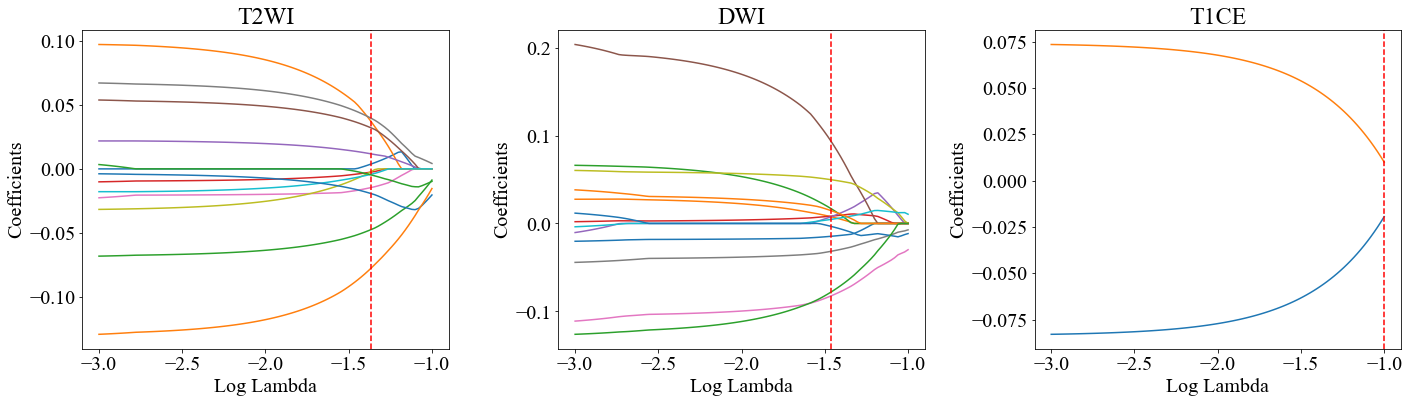

In [412]:
#这个图显示随着挑选出的lambda的变化，系数的变化走势
from sklearn import linear_model
plt.rc('font',family='Times New Roman') # rc方式设置字体
# Sci paper一般选用Arial格式或者Times New Roman 格式
plt.rcParams['font.family'] = 'Times New Roman' # 设置字体样式
plt.rcParams['font.size'] = '20' # 设置字体大小

#绘制误差棒图
plt.clf()
subfig_num = len(SSM_lasso_models)
print('='*10, f'Total {subfig_num} labeled mask', '='*10)	
title_list = ['T2WI', 'DWI', 'T1CE']
col = 3	# 设置子图列数
row = subfig_num//col 	# 通过子图数量和列数计算子图行数
if subfig_num%col > 0:
    row += 1
nfig = 0
fig, ax = plt.subplots(row, col, figsize=(20,18*row/col))  # 通过"sharex='col', sharey='row'"参数设置共享行列坐标轴
# 将ax统一成二维数组
if row == 1:
    ax = np.array([ax])
for i in range(subfig_num):
    lassoCV_x = lasso_sel_list[i].drop(tag_cols, axis=1)
    lassoCV_y = lasso_sel_list[i]['label']
    alpha_range = np.logspace(-3, -1, 100, base=10)
    # 使用path的到alphas_,并不会影响之前训练的最优alpha_和coef_的值
    alphas1, coefs, _ = SSM_lasso_models[i].path(lassoCV_x,lassoCV_y, alphas=alpha_range, max_iter=10000)
    alphas1 = np.log10(alphas1)
    coefs = coefs.T
    #ax[nfig//col, nfig%col].semilogx(alphas,coefs,'-')
    ax[nfig//col, nfig%col].plot(alphas1,coefs,'-')
    ax[nfig//col, nfig%col].axvline(np.log10(SSM_lasso_models[i].alpha_) , color='red', ls='--')  #dual_gap_
    ax[nfig//col, nfig%col].set_xlabel('Log Lambda')
    ax[nfig//col, nfig%col].set_ylabel('Coefficients')
    ax[nfig//col, nfig%col].set_title(title_list[i])
    nfig += 1
    
plt.tight_layout() # 防止标题重叠
plt.savefig(os.path.join(imgdir, 'lasso_coefs.png'), dpi=300)
plt.show()

========== Total 3 labeled mask ==========


<Figure size 432x288 with 0 Axes>

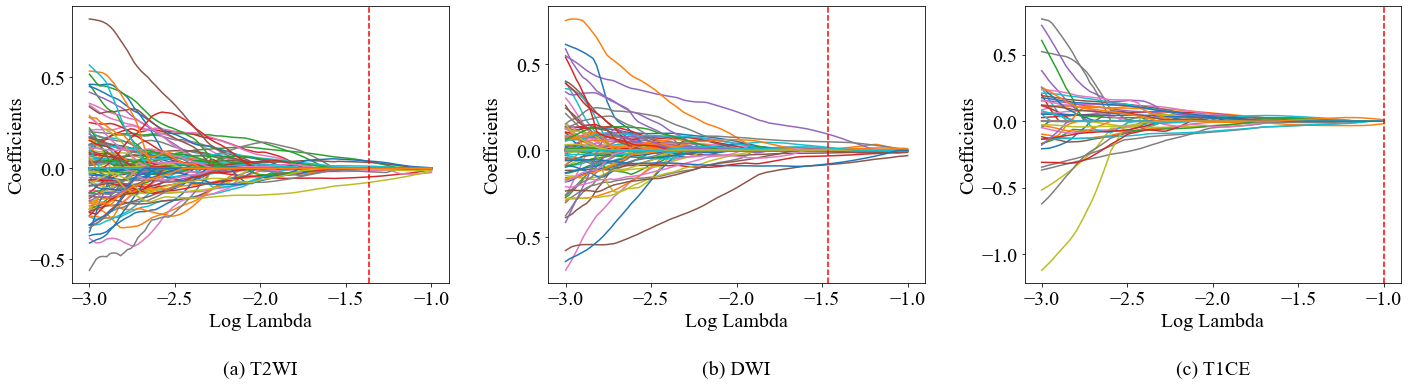

In [413]:
#这个图显示随着lambda的变化，系数的变化走势
from sklearn import linear_model
plt.rc('font',family='Times New Roman') # rc方式设置字体
# Sci paper一般选用Arial格式或者Times New Roman 格式
plt.rcParams['font.family'] = 'Times New Roman' # 设置字体样式
plt.rcParams['font.size'] = '20' # 设置字体大小

lasso_all_list = [pd.read_excel(os.path.join(datadir, 'feas_ttest_sel.xlsx'), sheet_name=f'sequence{num}') for num in sequence_id]
#绘制误差棒图
plt.clf()
subfig_num = len(SSM_lasso_models)
print('='*10, f'Total {subfig_num} labeled mask', '='*10)	
title_list = ['(a) T2WI', '(b) DWI', '(c) T1CE']
col = 3	# 设置子图列数
row = subfig_num//col 	# 通过子图数量和列数计算子图行数
if subfig_num%col > 0:
    row += 1
nfig = 0
fig, ax = plt.subplots(row, col, figsize=(20,18*row/col))  # 通过"sharex='col', sharey='row'"参数设置共享行列坐标轴
# 将ax统一成二维数组
if row == 1:
    ax = np.array([ax])
for i in range(subfig_num):
    lassoCV_x = lasso_all_list[i].drop(tag_cols, axis=1)
    lassoCV_y = lasso_all_list[i]['label']
    alpha_range = np.logspace(-3, -1, 100, base=10)
    # 使用path的到alphas_,并不会影响之前训练的最优alpha_和coef_的值
    alphas1, coefs, _ = SSM_lasso_models[i].path(lassoCV_x,lassoCV_y, alphas=alpha_range, max_iter=10000)
    coefs = coefs.T
    alphas1 = np.log10(alphas1)
    #ax[nfig//col, nfig%col].semilogx(alphas1,coefs,'-')
    ax[nfig//col, nfig%col].plot(alphas1,coefs,'-')
    ax[nfig//col, nfig%col].axvline(np.log10(SSM_lasso_models[i].alpha_) , color='red', ls='--')  #dual_gap_
    ax[nfig//col, nfig%col].set_xlabel('Log Lambda')
    ax[nfig//col, nfig%col].set_ylabel('Coefficients')
    ax[nfig//col, nfig%col].set_title(title_list[i], y=-0.35, fontsize=20)
    nfig += 1
    
plt.tight_layout() # 防止标题重叠
plt.savefig(os.path.join(imgdir, 'lasso_coefs_SSM.png'), dpi=300)
plt.show()

========== Total 3 labeled mask ==========


<Figure size 432x288 with 0 Axes>

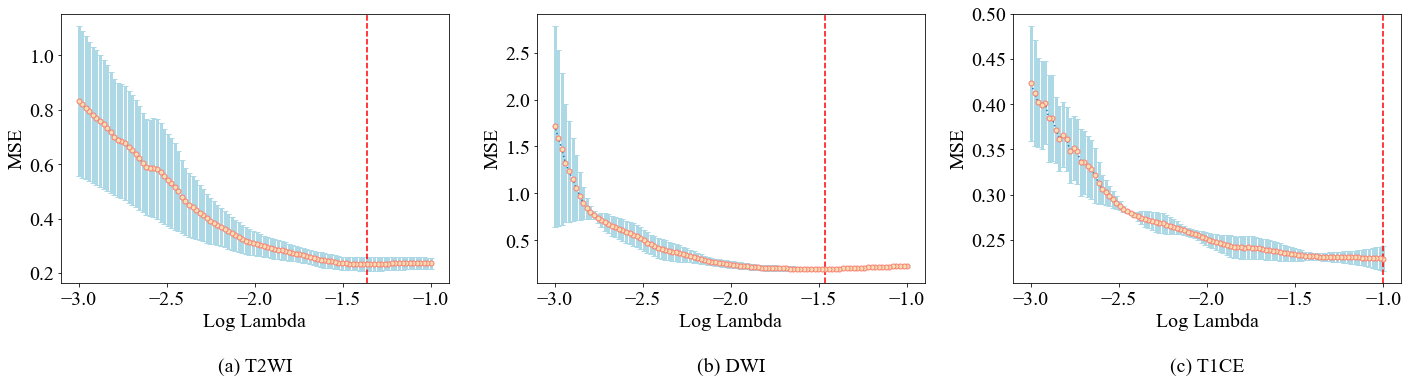

In [399]:
plt.rc('font',family='Times New Roman') # rc方式设置字体
# Sci paper一般选用Arial格式或者Times New Roman 格式
plt.rcParams['font.family'] = 'Times New Roman' # 设置字体样式
plt.rcParams['font.size'] = '20' # 设置字体大小

#绘制误差棒图
plt.clf()
subfig_num = len(SSM_lasso_models)
print('='*10, f'Total {subfig_num} labeled mask', '='*10)	
title_list = ['(a) T2WI', '(b) DWI', '(c) T1CE']
col = 3	# 设置子图列数
row = subfig_num//col 	# 通过子图数量和列数计算子图行数
if subfig_num%col > 0:
    row += 1
nfig = 0
fig, ax = plt.subplots(row, col, figsize=(20,18*row/col))  # 通过"sharex='col', sharey='row'"参数设置共享行列坐标轴
# 将ax统一成二维数组
if row == 1:
    ax = np.array([ax])
for i in range(subfig_num):
    lassoCV_model = SSM_lasso_models[i]
    MSEs = lassoCV_model.mse_path_
    mse = list()
    std = list()
    for m in MSEs:
        mse.append(np.mean(m))
        std.append(np.std(m))
    ax[nfig//col, nfig%col].errorbar(np.log10(lassoCV_model.alphas_), mse, std,fmt='o:', ecolor='lightblue', elinewidth=3,ms=5,mfc='wheat',mec='salmon',capsize=3)
    ax[nfig//col, nfig%col].axvline(np.log10(lassoCV_model.alpha_), color='red', ls='--')
    ax[nfig//col, nfig%col].set_title(title_list[i], y=-0.35, fontsize=20)
    ax[nfig//col, nfig%col].set_xlabel('Log Lambda')
    ax[nfig//col, nfig%col].set_ylabel('MSE')
    nfig += 1
plt.tight_layout() # 防止标题重叠
plt.savefig(os.path.join(imgdir, 'lasso_errorbar_SSM.png'), dpi=300)
plt.show()

========== Total 3 labeled mask ==========


<Figure size 432x288 with 0 Axes>

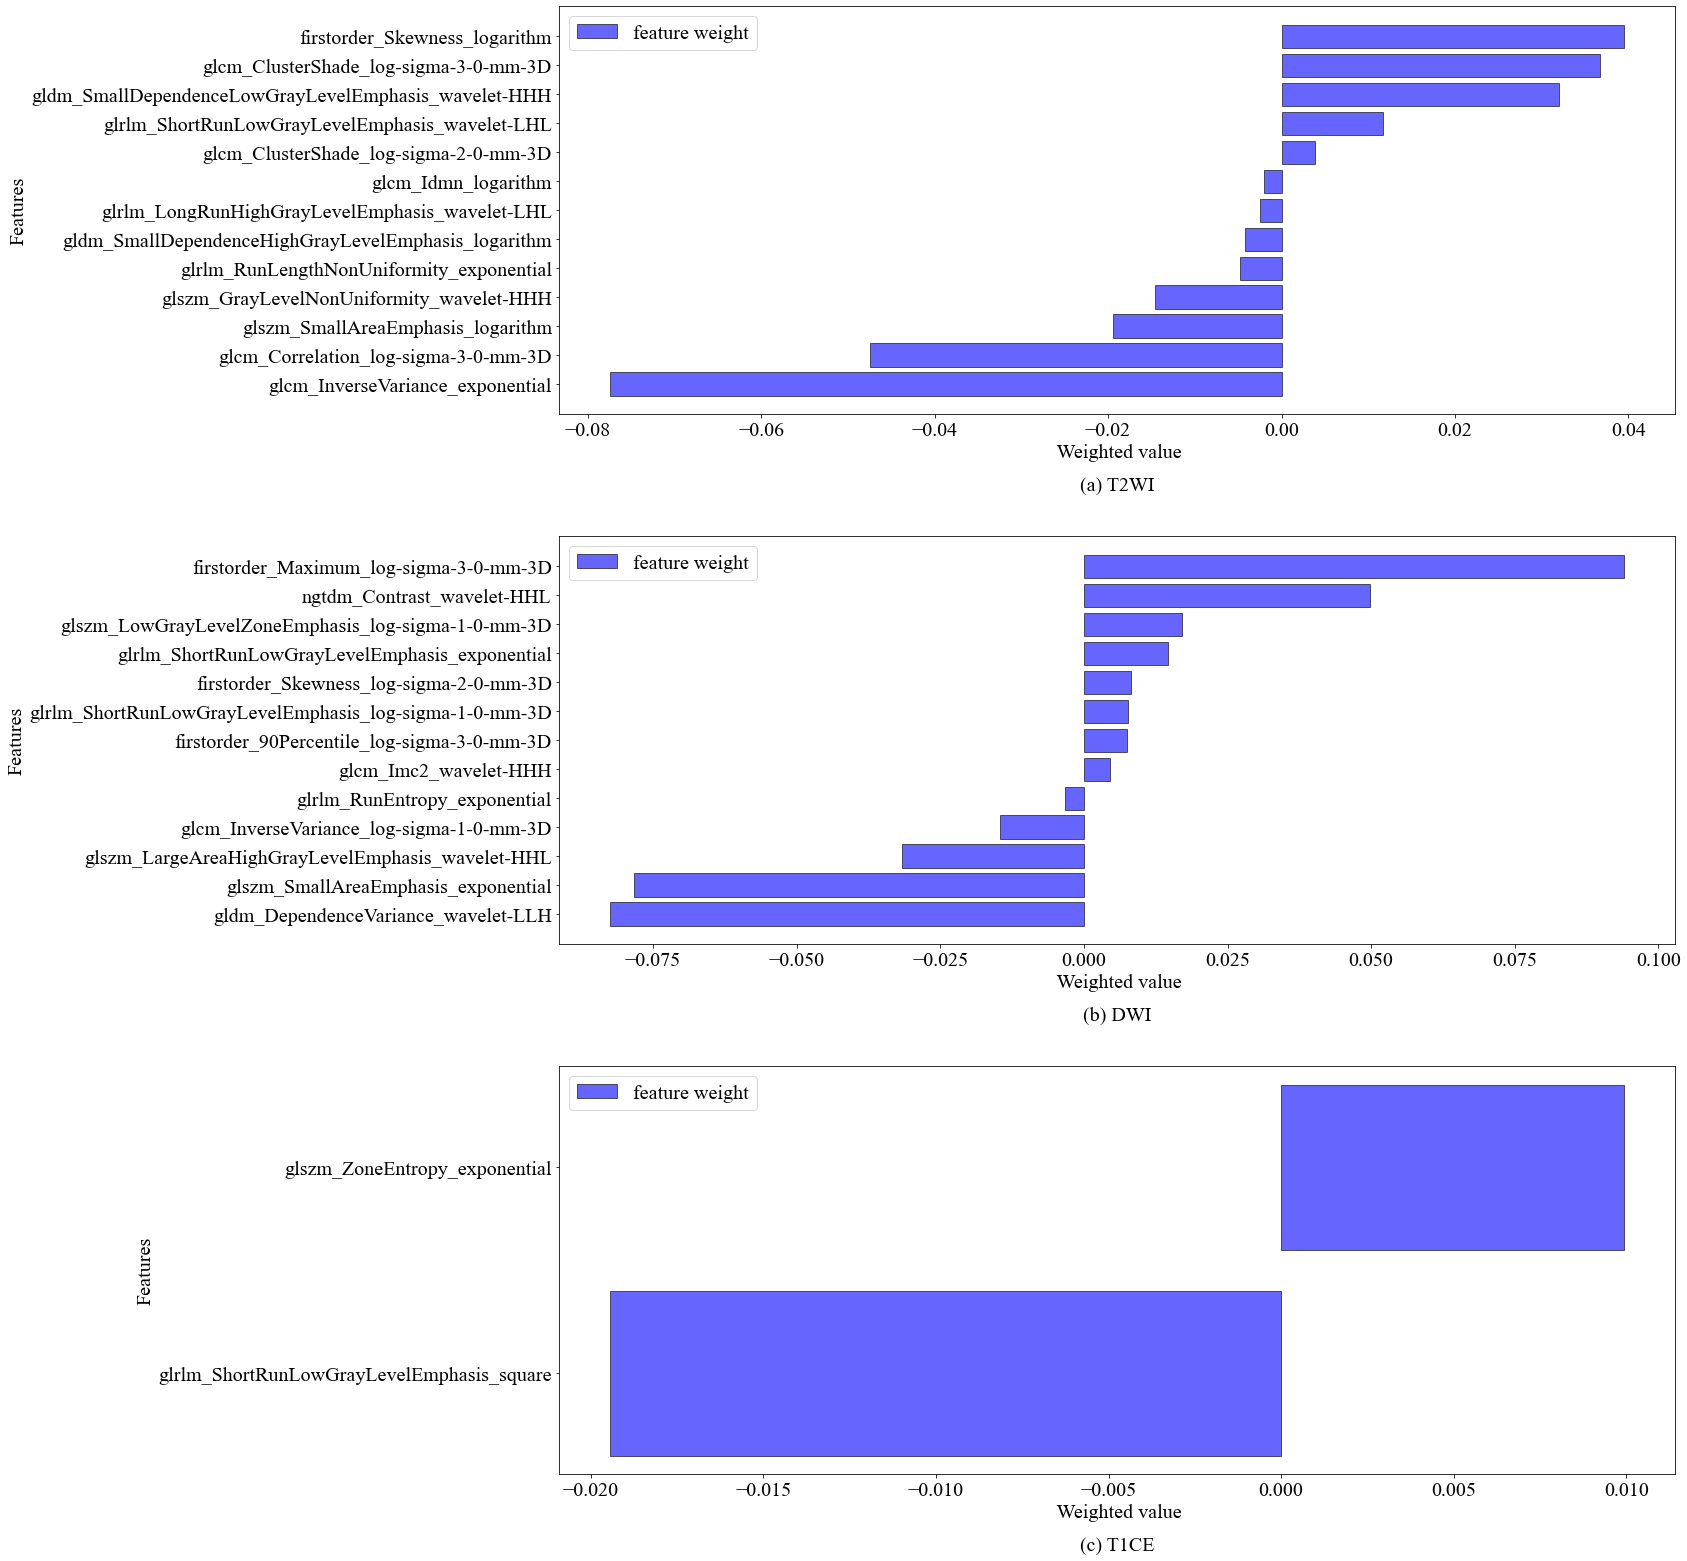

In [414]:
plt.rc('font',family='Times New Roman') # rc方式设置字体
# Sci paper一般选用Arial格式或者Times New Roman 格式
plt.rcParams['font.family'] = 'Times New Roman' # 设置字体样式
plt.rcParams['font.size'] = '20' # 设置字体大小

#绘制误差棒图
plt.clf()
subfig_num = len(SSM_lasso_models)
print('='*10, f'Total {subfig_num} labeled mask', '='*10)	
title_list = ['(a) T2WI', '(b) DWI', '(c) T1CE']
col = 1	# 设置子图列数
row = subfig_num//col 	# 通过子图数量和列数计算子图行数
if subfig_num%col > 0:
    row += 1
nfig = 0
fig, ax = plt.subplots(row, col, figsize=(20, int(9*row/col)))  # 通过"sharex='col', sharey='row'"参数设置共享行列坐标轴
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
# 将ax统一成二维数组
if row == 1:
    ax = np.array([ax])
if col == 1:
    ax = np.array([[x] for x in ax])
for i in range(subfig_num):
    #画一个特征系数的柱状图
    coefs = SSM_lasso_models[i].coef_
    coefs = coefs[coefs != 0]
    coefs = pd.Series(coefs, index=lasso_sel_list[i].drop(tag_cols, axis=1,errors='ignore').columns)
    weight = coefs[coefs != 0].to_dict()
    #根据值大小排列一下
    weight = dict(sorted(weight.items(),key=lambda x:x[1],reverse=False))
    ax[nfig//col, nfig%col].set_title(title_list[i], y=-0.20, fontsize=20)#标题，并设定字号大小
    ax[nfig//col, nfig%col].set_xlabel(f' Weighted value')#设置x轴，并设定字号大小
    ax[nfig//col, nfig%col].set_ylabel(u'Features')
    ax[nfig//col, nfig%col].barh(range(len(weight.values())), list(weight.values()),tick_label = list(weight.keys()),alpha=0.6, facecolor = 'blue', edgecolor = 'black', label='feature weight')
    ax[nfig//col, nfig%col].legend(loc=0)#图例展示位置，数字代表第几象限
    nfig+=1
#plt.tight_layout() # 防止标题重叠
plt.savefig(os.path.join(imgdir, 'lasso_features_weight_SSM.png'), dpi=300, bbox_inches='tight')
plt.show()

### (7) Use `mRMR` method 
+ All features need to be normalized from now on since the lassoCV filter select the features by normalized
+ remove redundant features and fuse the multi-series features into single
+ **Input**: Multi-series features in dataframe list.

In [8]:
# create some pandas data
from sklearn.datasets import make_classification
from mrmr import mrmr_classif
df_slist = [pd.read_excel(os.path.join(datadir, 'feas_lasso_sel.xlsx'), sheet_name=f'sequence{num}') for num in sequence_id]
# Scale the features since lasso used the scaled value.
df_slist = [features_norm(df) for df in df_slist]
mrmr_sel_list = []
mrmr_col_list = []
num_filter = [5, 5, 2]
# num_filter = [5, 5, 5]
for count, df in enumerate(df_slist):
    X = df.drop(tag_cols, axis=1)
    Y = df['label']
    sel_col = mrmr_classif(X, Y, num_filter[count])
    sel_col = tag_cols+sel_col
    sel_df = df[sel_col]
    mrmr_sel_list.append(sel_df)
    mrmr_col_list.append(sel_col)
    print('='*20)
    print('For series {} :'.format(count+2))
    print("筛选后剩下的特征数：{}个".format(len(sel_col)-len(tag_cols)))
    print('='*20)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]

For series 2 :
筛选后剩下的特征数：5个



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


For series 3 :
筛选后剩下的特征数：5个


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 211.20it/s]

For series 4 :
筛选后剩下的特征数：2个


In [416]:
writer = pd.ExcelWriter(os.path.join(datadir, 'feas_mrmr_sel.xlsx'))
for seq_, df in enumerate(mrmr_sel_list):
    df.to_excel(writer, f'sequence{seq_ + 2}', index=False)
writer.save()
info = f'{mrmr_sel_list[0].shape[1]-len(tag_cols)}, {mrmr_sel_list[1].shape[1]-len(tag_cols)} and {mrmr_sel_list[2].shape[1]-len(tag_cols)} \
                features selected for sequence 2, 3 and 4 by muse selector'
wprint(info)
feas_list = [df.columns.to_list()[5:] for df in mrmr_sel_list]
feas_list

=  5, 5 and 2                 features selected for sequence 2, 3 and 4 by muse selector  =


[['glszm_SmallAreaEmphasis_logarithm',
  'glcm_InverseVariance_exponential',
  'glszm_GrayLevelNonUniformity_wavelet-HHH',
  'firstorder_Skewness_logarithm',
  'glcm_Correlation_log-sigma-3-0-mm-3D'],
 ['gldm_DependenceVariance_wavelet-LLH',
  'ngtdm_Contrast_wavelet-HHL',
  'firstorder_Skewness_log-sigma-2-0-mm-3D',
  'glcm_Imc2_wavelet-HHH',
  'glrlm_RunEntropy_exponential'],
 ['glrlm_ShortRunLowGrayLevelEmphasis_square',
  'glszm_ZoneEntropy_exponential']]

========== Total 3 labeled mask ==========


<Figure size 432x288 with 0 Axes>

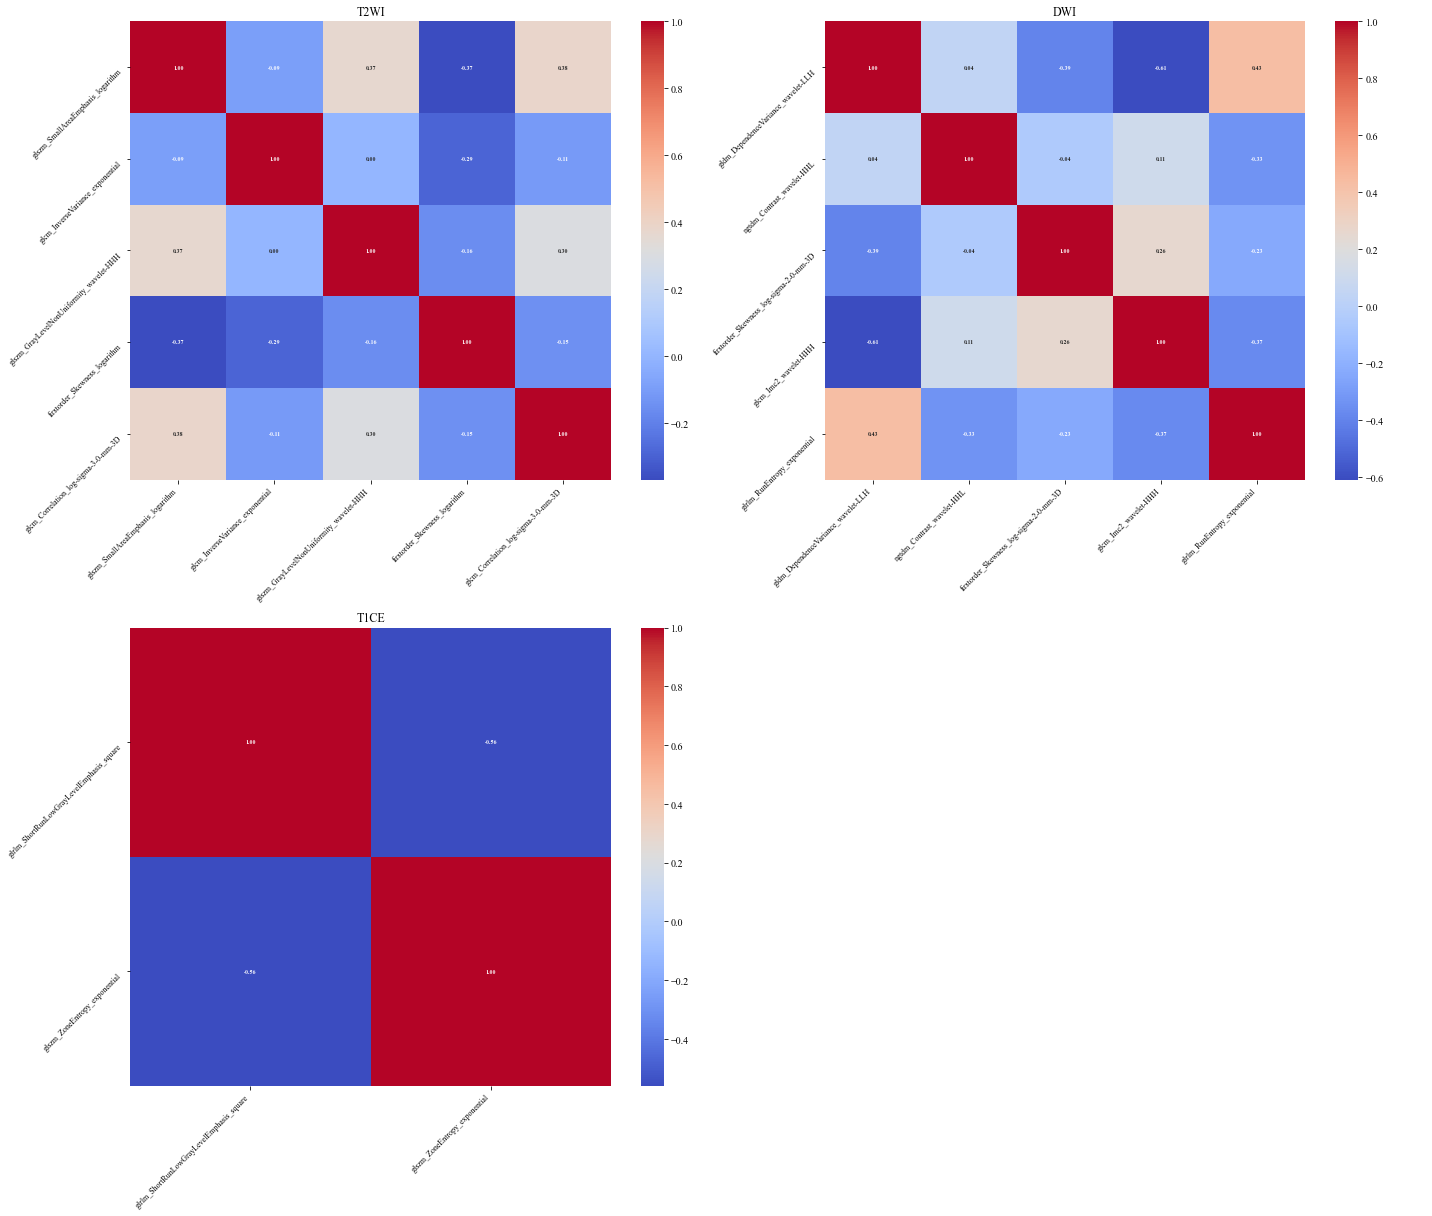

In [417]:
plt.rc('font',family='Times New Roman') # rc方式设置字体
# Sci paper一般选用Arial格式或者Times New Roman 格式
plt.rcParams['font.family'] = 'Times New Roman' # 设置字体样式
plt.rcParams['font.size'] = '10' # 设置字体大小

#绘制误差棒图
plt.clf()
subfig_num = 3
print('='*10, f'Total {subfig_num} labeled mask', '='*10)	
title_list = ['T2WI', 'DWI', 'T1CE']
col = 2	# 设置子图列数
row = subfig_num//col 	# 通过子图数量和列数计算子图行数
if subfig_num%col > 0:
    row += 1
nfig = 0
fig, ax = plt.subplots(row, col, figsize=(20,17*row/col))  # 通过"sharex='col', sharey='row'"参数设置共享行列坐标轴
# 将ax统一成二维数组
if row == 1:
    ax = np.array([ax])
for i in range(subfig_num):
    # The fusion features
    hemp_df = mrmr_sel_list[i].iloc[:,3:]
    sns.heatmap(hemp_df.corr(),annot=True,fmt='.2f',cmap='coolwarm',annot_kws={'size':6,'weight':'bold', },ax=ax[nfig//col, nfig%col])#绘制混淆矩阵
    ax[nfig//col, nfig%col].set_xticklabels(ax[nfig//col, nfig%col].get_xticklabels(), fontdict={'size':8}, rotation=45,va="top",ha="right")
    ax[nfig//col, nfig%col].set_yticklabels(ax[nfig//col, nfig%col].get_yticklabels(), fontdict={'size':8}, rotation=45, va='top', ha='right')
    ax[nfig//col, nfig%col].set_title(title_list[i])
    nfig += 1
# 去除未使用的子图边框
for i in range(subfig_num, row*col):
    ax[i//col, i%col].axis('off')
plt.tight_layout() # 防止标题重叠
plt.savefig(os.path.join(imgdir, 'SSM_corr.png'), dpi=300)
plt.show()

### (8) Sequence fusion
+ DSM (Best two sequences)
+ TSM (Any two sequences)
+ ASM (All sequences)

In [9]:

# Add suffix for the colunms' name for the df.
def feas_name_addsux(df, sux, exclude_columns=[]):
    newcolumn = [name+str(sux) if name not in exclude_columns else name for name in list(df.columns) ]
    df_copy = df.copy()
    df_copy.columns=newcolumn
    return df_copy
 
def df_parallel_fusion(df_list, series_index, pid='pid', *nonfeas):
    # The list which are not features' columns
    no_feas_list = list(nonfeas)+[series_index, pid]
    # Chage name for the df.columns.
    df_list1 = [feas_name_addsux(df, str(df.at[0, series_index]), no_feas_list) for df in df_list]
    # Remain the 'pid' for the first df. 
    df_fusion = df_list1[0].drop(list(nonfeas)+[series_index], axis=1)
    for i in range(len(df_list)-1):
        feas_list = [col for col in list(df_list1[i+1]) if col not in list(nonfeas)+[series_index]]
        df_fusion = pd.merge(df_fusion, df_list1[i+1][feas_list], on=pid, how='inner')
    return df_fusion

####
def df_part_fusion(df_list, series_index, abs_cols, pid='pid', *nonfeas):
    abs_cols_list = [[col for col in df.columns if col in [pid]+abs_cols] for df in df_list]
    abs_df_list = [df[cols] for df, cols in zip(df_list, abs_cols_list)]  # cols include pid and abs_col
    abs_df = abs_df_list[0]
    for df in abs_df_list[1:]:
        cols_add = [col for col in df.columns if col not in abs_df.columns]
        abs_df = pd.merge(abs_df, df[[pid]+cols_add], on=pid, how='inner')
    fusion_cols_list = [[col for col in df.columns if col not in abs_cols] for df in df_list]
    fusion_df_list = [df[cols] for df,cols in zip(df_list,fusion_cols_list)]  # cols include pid and abs_col
    fusion_df = df_parallel_fusion(fusion_df_list, series_index, pid, *nonfeas)
    fusion_df = pd.merge(fusion_df, abs_df, on=pid, how='inner')
    return fusion_df 

#### DSM fusion and selected by lasso.

In [11]:
df_slist = [pd.read_excel(os.path.join(datadir, 'feas_mrmr_sel.xlsx'), sheet_name=f'sequence{num}') for num in sequence_id]
tag_df = df_slist[0][['pid', 'label']]
clin_cols = ['pid', 'label']

## Any two sequence fusion.
dfuse_list = []
for i in range(len(df_slist)):
    fuse_df_list = [df_slist[k] for k in range(len(df_slist)) if k != i]
    fuse_df = df_parallel_fusion(fuse_df_list, 'series', *tag_cols)
    fuse_df = pd.merge(tag_df, fuse_df, on='pid', how='inner')
    dfuse_list.append(fuse_df)

writer = pd.ExcelWriter(os.path.join(datadir, 'feas_DSM.xlsx'))
for seq_, df in enumerate(dfuse_list):
    df.to_excel(writer, f'no_sequence{seq_ + 2}', index=False)
writer.save()
info = f'{dfuse_list[0].shape[1]-2}, {dfuse_list[1].shape[1]-2} and {dfuse_list[2].shape[1]-2} \
                features for no_sequence 2, 3 and 4 fusion.'
wprint(info)

=   7, 7 and 10                 features for no_sequence 2, 3 and 4 fusion.    =


In [21]:
df_slist = [pd.read_excel(os.path.join(datadir, 'feas_DSM.xlsx'), sheet_name=f'no_sequence{num}') for num in sequence_id]
DSM_models = []
lasso_cols = []
alphas = np.logspace(-2, -1, 100, base=10)
max_iter = 100000
lasso_sel_list = []
for count, df in enumerate(df_slist):
    lassoCV_model = feas_sel_Lasso(df, alphas=alphas, max_iter=max_iter, cv=2)
    feas_col = [col for col in list(df.columns) if col not in tag_cols1]
    coefs = pd.Series(lassoCV_model.coef_, index=feas_col)
    lasso_sel_col = tag_cols1 + list(coefs[coefs !=0].index)
    lasso_df = df[lasso_sel_col]
    lasso_cols.append(lasso_sel_col)
    DSM_models.append(lassoCV_model)
    lasso_sel_list.append(lasso_df)

In [22]:
for i, model in enumerate(DSM_models):
    joblib.dump(model, os.path.join(modeldir, f'DSM_lasso_{i+2}.model'))
writer = pd.ExcelWriter(os.path.join(datadir, 'DSM_feas_lasso_sel.xlsx'))
for seq_, df in enumerate(lasso_sel_list):
    df.to_excel(writer, f'no_sequence{seq_ + 2}', index=False)
writer.save()
info = f'{lasso_sel_list[0].shape[1]-2}, {lasso_sel_list[1].shape[1]-2} and {lasso_sel_list[2].shape[1]-2} features selected for sequence 2, 3 and 4 by lasso selector'
info1 = f'The best alpha value are {DSM_models[0].alpha_}, {DSM_models[1].alpha_} and {DSM_models[2].alpha_} for sequence 2, 3 and 4, respectively'
wprint(info)
wprint(info1)

=    6, 7 and 9 features selected for sequence 2, 3 and 4 by lasso selector    =
=  The best alpha value are 0.010235310218990263, 0.011497569953977356 and 0.019179102616724886 for sequence 2, 3 and 4, respectively  =


========== Total 3 labeled mask ==========


<Figure size 432x288 with 0 Axes>

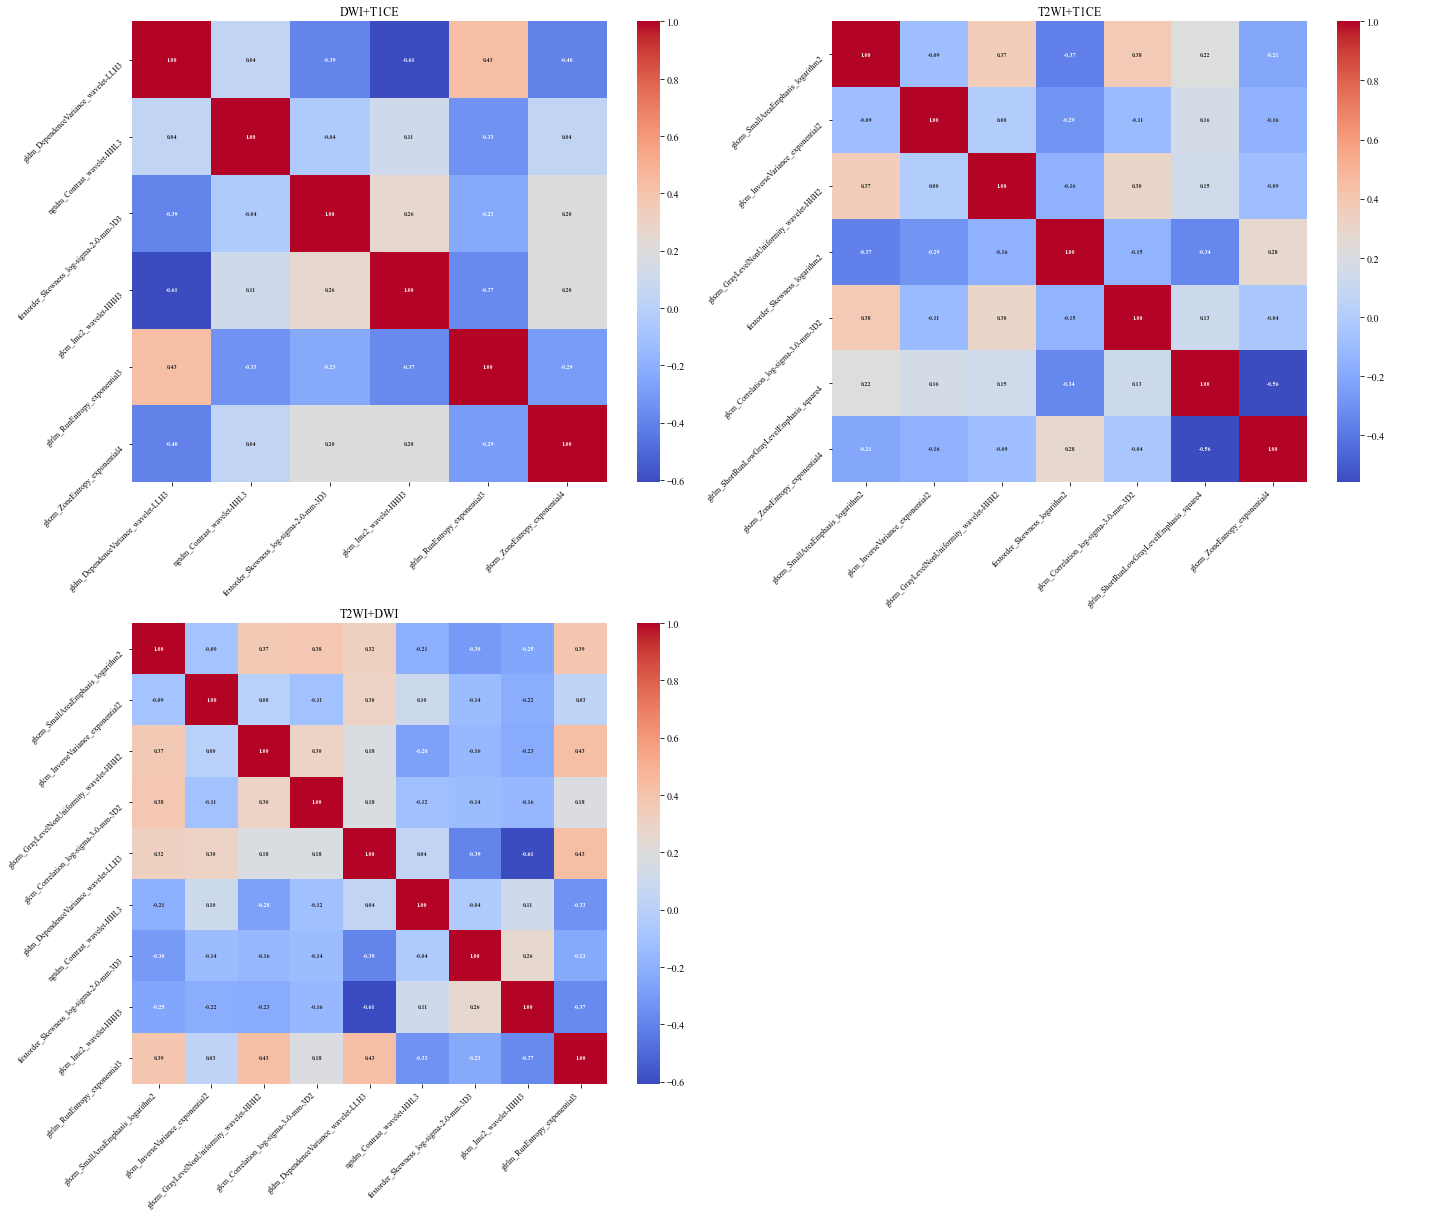

In [23]:
plt.rc('font',family='Times New Roman') # rc方式设置字体
# Sci paper一般选用Arial格式或者Times New Roman 格式
plt.rcParams['font.family'] = 'Times New Roman' # 设置字体样式
plt.rcParams['font.size'] = '10' # 设置字体大小

#绘制误差棒图
plt.clf()
subfig_num = 3
print('='*10, f'Total {subfig_num} labeled mask', '='*10)	
title_list = ['DWI+T1CE', 'T2WI+T1CE', 'T2WI+DWI']
col = 2	# 设置子图列数
row = subfig_num//col 	# 通过子图数量和列数计算子图行数
if subfig_num%col > 0:
    row += 1
nfig = 0
fig, ax = plt.subplots(row, col, figsize=(20,17*row/col))  # 通过"sharex='col', sharey='row'"参数设置共享行列坐标轴
# 将ax统一成二维数组
if row == 1:
    ax = np.array([ax])
for i in range(subfig_num):
    # The fusion features
    hemp_df = lasso_sel_list[i].iloc[:,2:]
    sns.heatmap(hemp_df.corr(),annot=True,fmt='.2f',cmap='coolwarm',annot_kws={'size':6,'weight':'bold', },ax=ax[nfig//col, nfig%col])#绘制混淆矩阵
    ax[nfig//col, nfig%col].set_xticklabels(ax[nfig//col, nfig%col].get_xticklabels(), fontdict={'size':8}, rotation=45,va="top",ha="right")
    ax[nfig//col, nfig%col].set_yticklabels(ax[nfig//col, nfig%col].get_yticklabels(), fontdict={'size':8}, rotation=45, va='top', ha='right')
    ax[nfig//col, nfig%col].set_title(title_list[i])
    nfig += 1
# 去除未使用的子图边框
for i in range(subfig_num, row*col):
    ax[i//col, i%col].axis('off')
plt.tight_layout() # 防止标题重叠
plt.savefig(os.path.join(imgdir, 'DSM_sequence_corr.png'), dpi=300)
plt.show()

========== Total 1 labeled mask ==========


<Figure size 432x288 with 0 Axes>

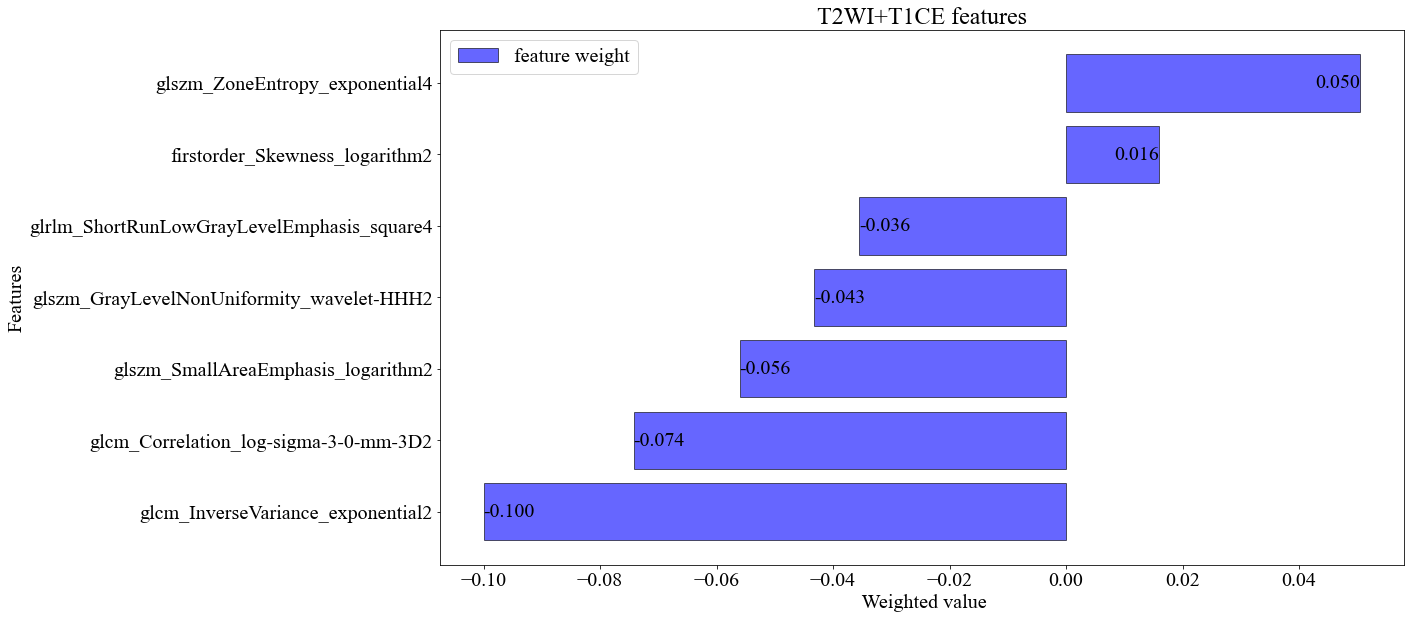

In [40]:
plt.rc('font',family='Times New Roman') # rc方式设置字体
# Sci paper一般选用Arial格式或者Times New Roman 格式
plt.rcParams['font.family'] = 'Times New Roman' # 设置字体样式
plt.rcParams['font.size'] = '20' # 设置字体大小

#绘制误差棒图
plt.clf()
subfig_num = 1
print('='*10, f'Total {subfig_num} labeled mask', '='*10)	
title_list = ['T2WI', 'DWI', 'T1CE']
col = 1	# 设置子图列数
row = subfig_num//col 	# 通过子图数量和列数计算子图行数
if subfig_num%col > 0:
    row += 1
nfig = 0
fig, ax = plt.subplots(1, 1, figsize=(20, int(9*row/col)))  # 通过"sharex='col', sharey='row'"参数设置共享行列坐标轴
#画一个特征系数的柱状图
coefs = DSM_models[1].coef_
coefs = coefs[coefs != 0]
coefs = pd.Series(coefs, index=lasso_sel_list[1].drop(clin_cols, axis=1).columns)
weight = coefs[coefs != 0].to_dict()
#根据值大小排列一下
weight = dict(sorted(weight.items(),key=lambda x:x[1],reverse=False))
ax.set_title(f'T2WI+T1CE features')#标题，并设定字号大小
ax.set_xlabel(f' Weighted value')#设置x轴，并设定字号大小
ax.set_ylabel(u'Features')
bar = ax.barh(range(len(weight.values())), list(weight.values()),tick_label = list(weight.keys()),alpha=0.6, facecolor = 'blue', edgecolor = 'black', label='feature weight')
#添加数据标签
for rect in bar:
    w=rect.get_width()
    if w > 0:
        ax.text(w,rect.get_y()+rect.get_height()/2,'%.3f'%round(float(w),3),ha='right',va='center')
    else:
        ax.text(w,rect.get_y()+rect.get_height()/2,'%.3f'%round(float(w),3),ha='left',va='center')
ax.legend(loc=0)#图例展示位置，数字代表第几象限
plt.tight_layout() # 防止标题重叠
plt.savefig(os.path.join(imgdir, 'DSM_features_weight.png'), dpi=300,bbox_inches='tight')
plt.show()

========== Total 1 labeled mask ==========


<Figure size 432x288 with 0 Axes>

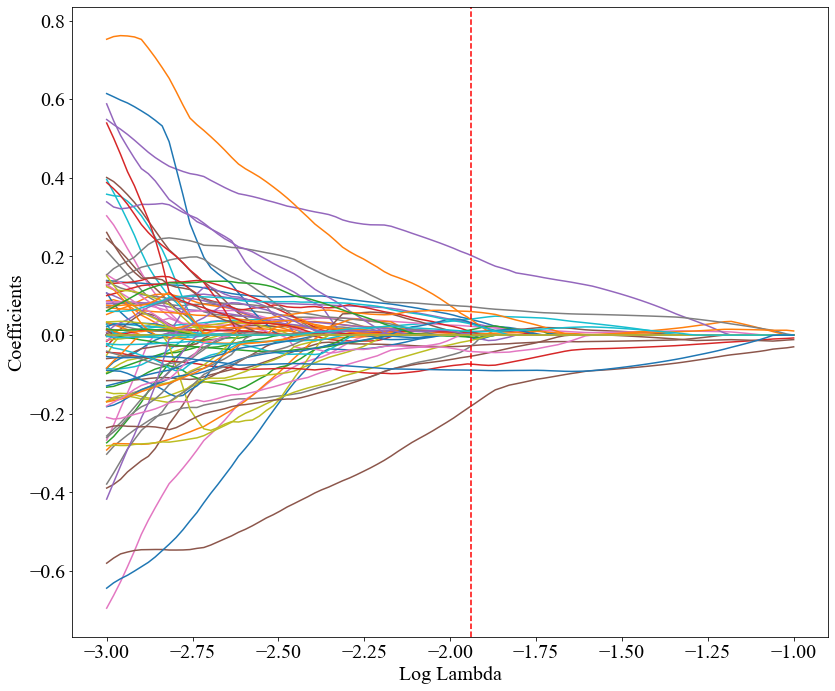

In [30]:
#这个图显示随着lambda的变化，系数的变化走势
from sklearn import linear_model
plt.rc('font',family='Times New Roman') # rc方式设置字体
# Sci paper一般选用Arial格式或者Times New Roman 格式
plt.rcParams['font.family'] = 'Times New Roman' # 设置字体样式
plt.rcParams['font.size'] = '20' # 设置字体大小

lasso_all_list = df_slist
lasso_all_list = [pd.read_excel(os.path.join(datadir, 'feas_ttest_sel.xlsx'), sheet_name=f'sequence{num}') for num in sequence_id]
#绘制误差棒图
plt.clf()
subfig_num = 1
print('='*10, f'Total {subfig_num} labeled mask', '='*10)	
title_list = ['T2WI', 'DWI', 'T1CE']
col = 3	# 设置子图列数
row = subfig_num//col 	# 通过子图数量和列数计算子图行数
if subfig_num%col > 0:
    row += 1
nfig = 0
fig, ax = plt.subplots(1, 1, figsize=(12,10))  # 通过"sharex='col', sharey='row'"参数设置共享行列坐标轴
#lassoCV_x = lasso_sel_list[1].drop(tag_cols1, axis=1)
lassoCV_x = lasso_all_list[1].drop(tag_cols, axis=1)
lassoCV_y = lasso_sel_list[1]['label']
alpha_range = np.logspace(-3, -1, 100, base=10)
# 使用path的到alphas_,并不会影响之前训练的最优alpha_和coef_的值
alphas1, coefs, _ = DSM_models[1].path(lassoCV_x,lassoCV_y, alphas=alpha_range, max_iter=10000)
coefs = coefs.T
alphas1 = np.log10(alphas1)
ax.plot(alphas1,coefs,'-')
ax.axvline(np.log10(DSM_models[1].alpha_) , color='red', ls='--')  #dual_gap_

ax.set_xlabel('Log Lambda')
ax.set_ylabel('Coefficients')
#ax.set_title('T2WI+T1CE')
nfig += 1
    
plt.tight_layout() # 防止标题重叠
plt.savefig(os.path.join(imgdir, 'DSM_lasso_coefs.png'), dpi=300,bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

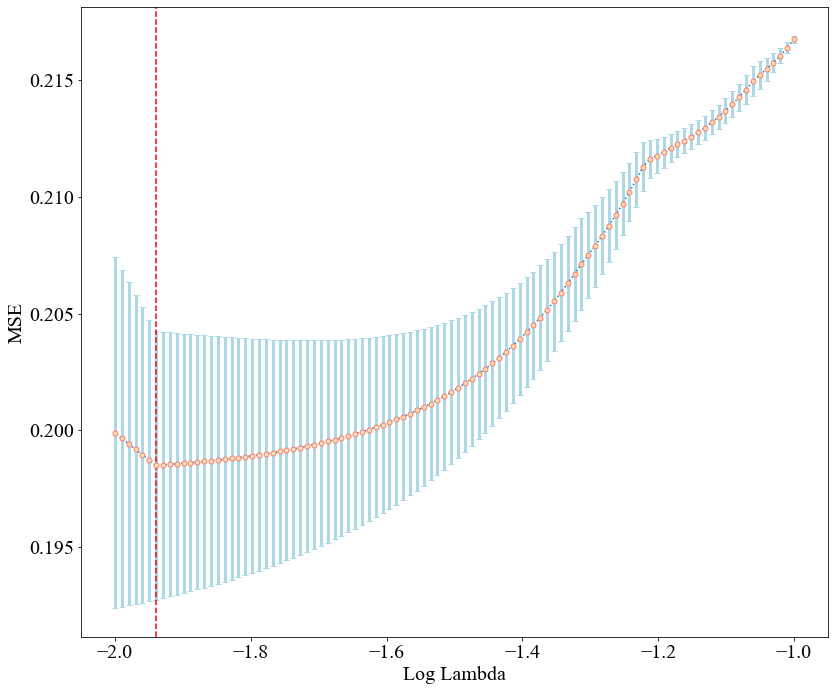

In [555]:
plt.rc('font',family='Times New Roman') # rc方式设置字体
# Sci paper一般选用Arial格式或者Times New Roman 格式
plt.rcParams['font.family'] = 'Times New Roman' # 设置字体样式
plt.rcParams['font.size'] = '20' # 设置字体大小

#绘制误差棒图
plt.clf()
col = 1	# 设置子图列数
row = 1
nfig = 0
fig, ax = plt.subplots(row, col, figsize=(12,10))  # 通过"sharex='col', sharey='row'"参数设置共享行列坐标轴
# 将ax统一成二维数组
lassoCV_model = DSM_models[1]
MSEs = lassoCV_model.mse_path_
mse=[]
std=[]
for m in MSEs:
    mse.append(np.mean(m))
    std.append(np.std(m))
ax.errorbar(np.log10(lassoCV_model.alphas_), mse, std,fmt='o:', ecolor='lightblue', elinewidth=3,ms=5,mfc='wheat',mec='salmon',capsize=3)
ax.axvline(np.log10(lassoCV_model.alpha_), color='red', ls='--')
#ax.set_title(title_list[i], y=-0.35, fontsize=20)
ax.set_xlabel('Log Lambda')
ax.set_ylabel('MSE')
nfig += 1
plt.tight_layout() # 防止标题重叠
plt.savefig(os.path.join(imgdir, 'lasso_errorbar_DSM.png'), dpi=300)
plt.show()

#### DSM mrmr.

In [556]:
# create some pandas data
from sklearn.datasets import make_classification
from mrmr import mrmr_classif
df_slist = [pd.read_excel(os.path.join(datadir, 'DSM_feas_lasso_sel.xlsx'), sheet_name=f'no_sequence{num}') for num in sequence_id]
# Scale the features since lasso used the scaled value.
df_slist = [features_norm(df) for df in df_slist]
mrmr_sel_list = []
mrmr_col_list = []
num_filter = [7, 7, 7]
for count, df in enumerate(df_slist):
    X = df.drop(tag_cols1, axis=1)
    Y = df['label']
    sel_col = mrmr_classif(X, Y, num_filter[count])
    sel_col = tag_cols1+sel_col
    sel_df = df[sel_col]
    mrmr_sel_list.append(sel_df)
    mrmr_col_list.append(sel_col)
    info="筛选后剩下的特征数：{}个".format(len(sel_col)-len(tag_cols1))
    wprint(info)

100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

=                       筛选后剩下的特征数：6个                       =



100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

=                       筛选后剩下的特征数：7个                       =



100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

=                       筛选后剩下的特征数：7个                       =


In [557]:
tmp_df = df_slist[1]
X = tmp_df.drop(tag_cols1, axis=1)
Y = df['label']
sel_col, relavance, redundance = mrmr_classif(X, Y, 7, return_scores=True)

100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


(7,)


<Figure size 432x288 with 0 Axes>

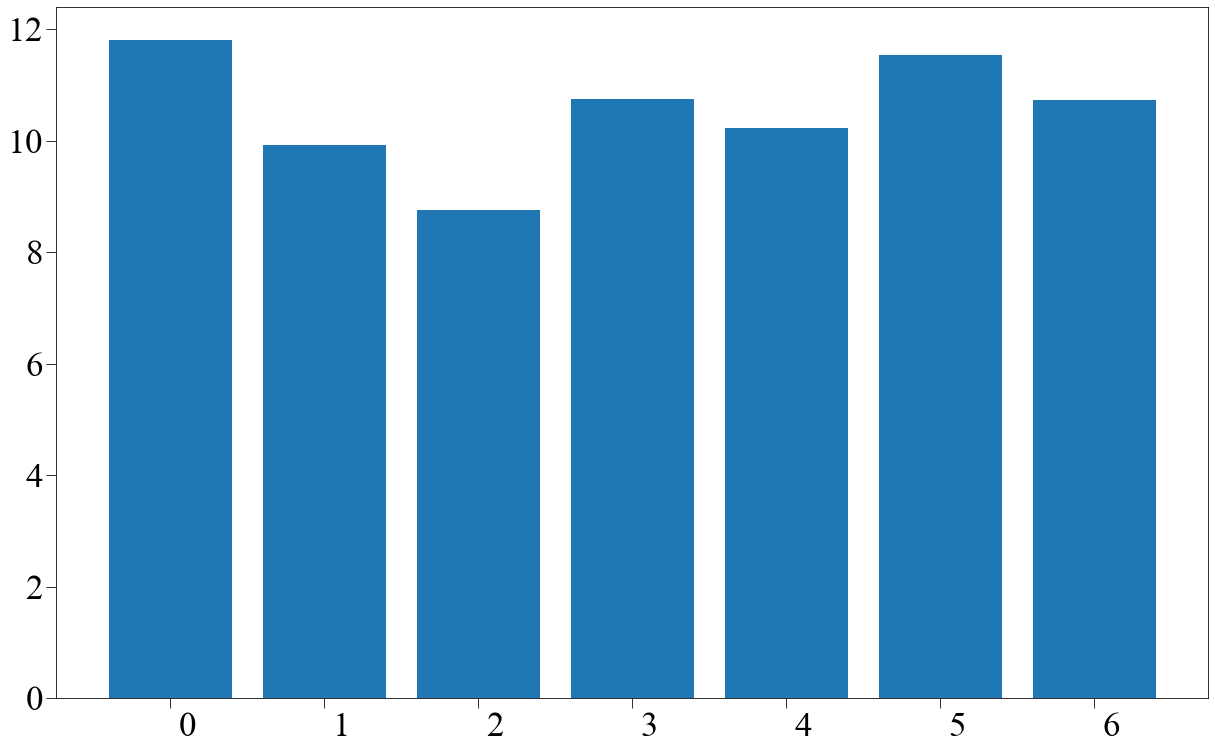

In [558]:
print(relavance.shape)
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, ScalarFormatter
plt.clf()
fig = plt.figure(figsize=(20,12))
# Set offset for margin
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
#ax = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(20, 20))
ax = fig.add_axes([left,bottom,width,height])
ax.bar(relavance.index, relavance.values)#, range=(0,500))
# Set x, y-axis label and fontsize.
# ax.set_ylabel('ICC value')
# ax.set_xlabel('Features')
ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 1
yinter = 2.0 
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.0f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
fig.savefig("./IMG/DSM_mRMR_relevance.png", dpi=300, bbox_inches='tight')

In [559]:
DSM_slit = mrmr_sel_list
writer = pd.ExcelWriter(os.path.join(datadir, 'DSM_feas_mrmr_sel.xlsx'))
for seq_, df in enumerate(mrmr_sel_list):
    df.to_excel(writer, f'no_sequence{seq_ + 2}', index=False)
writer.save()
info = f'{mrmr_sel_list[0].shape[1]-len(tag_cols1)}, {mrmr_sel_list[1].shape[1]-len(tag_cols1)} and {mrmr_sel_list[2].shape[1]-len(tag_cols1)} \
                features selected for sequence 2, 3 and 4 by muse selector'
wprint(info)
feas_list = [df.columns.to_list()[2:] for df in mrmr_sel_list]
feas_list

=  6, 7 and 7                 features selected for sequence 2, 3 and 4 by muse selector  =


[['gldm_DependenceVariance_wavelet-LLH3',
  'ngtdm_Contrast_wavelet-HHL3',
  'glszm_ZoneEntropy_exponential4',
  'glcm_Imc2_wavelet-HHH3',
  'firstorder_Skewness_log-sigma-2-0-mm-3D3',
  'glrlm_RunEntropy_exponential3'],
 ['glszm_SmallAreaEmphasis_logarithm2',
  'glcm_InverseVariance_exponential2',
  'glrlm_ShortRunLowGrayLevelEmphasis_square4',
  'glszm_GrayLevelNonUniformity_wavelet-HHH2',
  'glcm_Correlation_log-sigma-3-0-mm-3D2',
  'glszm_ZoneEntropy_exponential4',
  'firstorder_Skewness_logarithm2'],
 ['gldm_DependenceVariance_wavelet-LLH3',
  'ngtdm_Contrast_wavelet-HHL3',
  'glcm_Correlation_log-sigma-3-0-mm-3D2',
  'glcm_InverseVariance_exponential2',
  'glrlm_RunEntropy_exponential3',
  'glcm_Imc2_wavelet-HHH3',
  'glszm_SmallAreaEmphasis_logarithm2']]

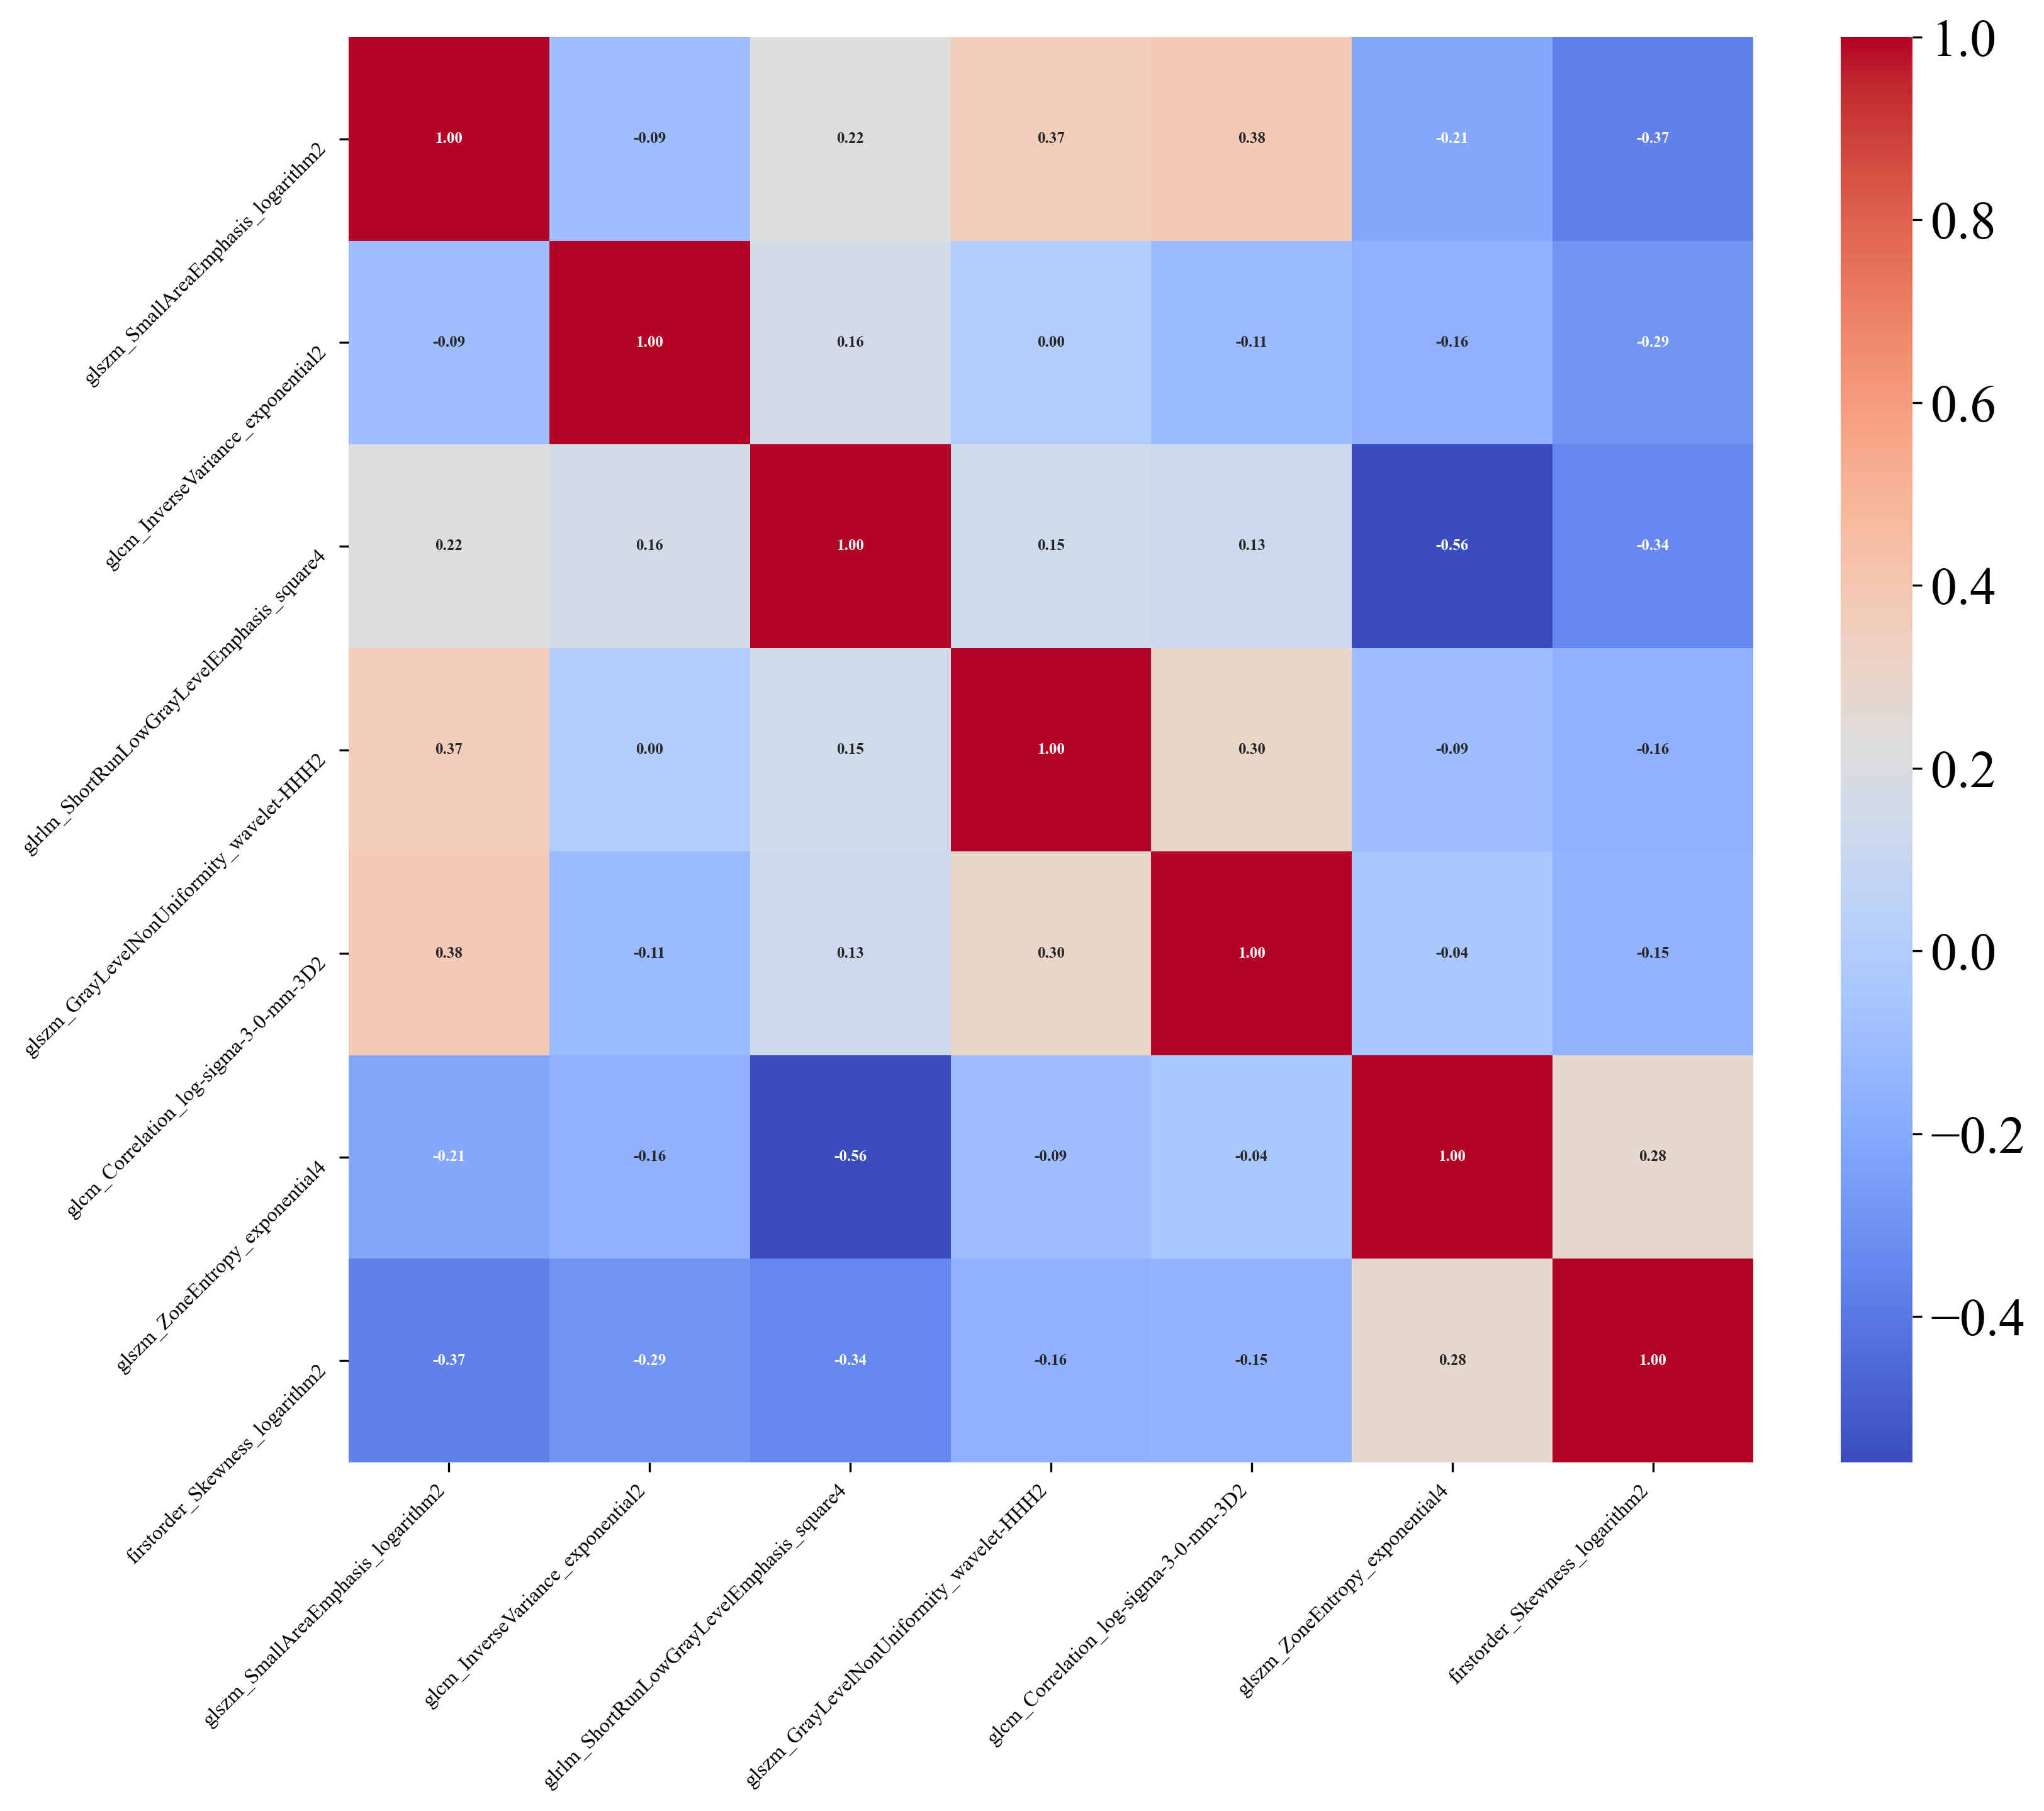

In [560]:
# 绘制特征相关系数热力图
# The fusion features
hemp_df = mrmr_sel_list[1].iloc[:,2:]
f, ax= plt.subplots(figsize = (12, 10),dpi=300)
sns.heatmap(hemp_df.corr(),annot=True,fmt='.2f',cmap='coolwarm',annot_kws={'size':6,'weight':'bold', },ax=ax)#绘制混淆矩阵
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'size':8}, rotation=45,va="top",ha="right")
ax.set_yticklabels(ax.get_yticklabels(), fontdict={'size':8}, rotation=45, va='top', ha='right')
plt.savefig('IMG/DSM_fusion_hempmap.png',dpi=300)
plt.show()

#### ASM fusion and selected by lasso.

In [561]:
## All sequences fusion.
df_slist = [pd.read_excel(os.path.join(datadir, 'feas_mrmr_sel.xlsx'), sheet_name=f'sequence{num}') for num in sequence_id]
df_label = df_slist[0][['pid', 'label']]
afuse_df = df_parallel_fusion(df_slist, 'series', 'pid', 'mask', 'image','label')
afuse_df = pd.merge(df_label, afuse_df, on='pid', how='inner')
afuse_df = afuse_df.sample(frac=1.0, random_state=random_state)
afuse_df.to_excel(os.path.join(datadir, 'ASM_feas.xlsx'), index=False)

In [562]:
df = pd.read_excel(os.path.join(datadir, 'ASM_feas.xlsx'))
alphas = np.logspace(-3, -1, 100, base=10)
max_iter = 100000
lassoCV_model = feas_sel_Lasso(df, alphas=alphas, max_iter=max_iter)
feas_col = [col for col in list(df.columns) if col not in tag_cols1]
coefs = pd.Series(lassoCV_model.coef_, index=feas_col)
lasso_sel_col = tag_cols1 + list(coefs[coefs !=0].index)
lasso_df = df[lasso_sel_col]
lasso_df.to_csv(os.path.join(datadir, 'ASM_feas_lasso_sel.csv'),index=0)
print(len(lasso_sel_col)-2, ' feas retained.')

11  feas retained.


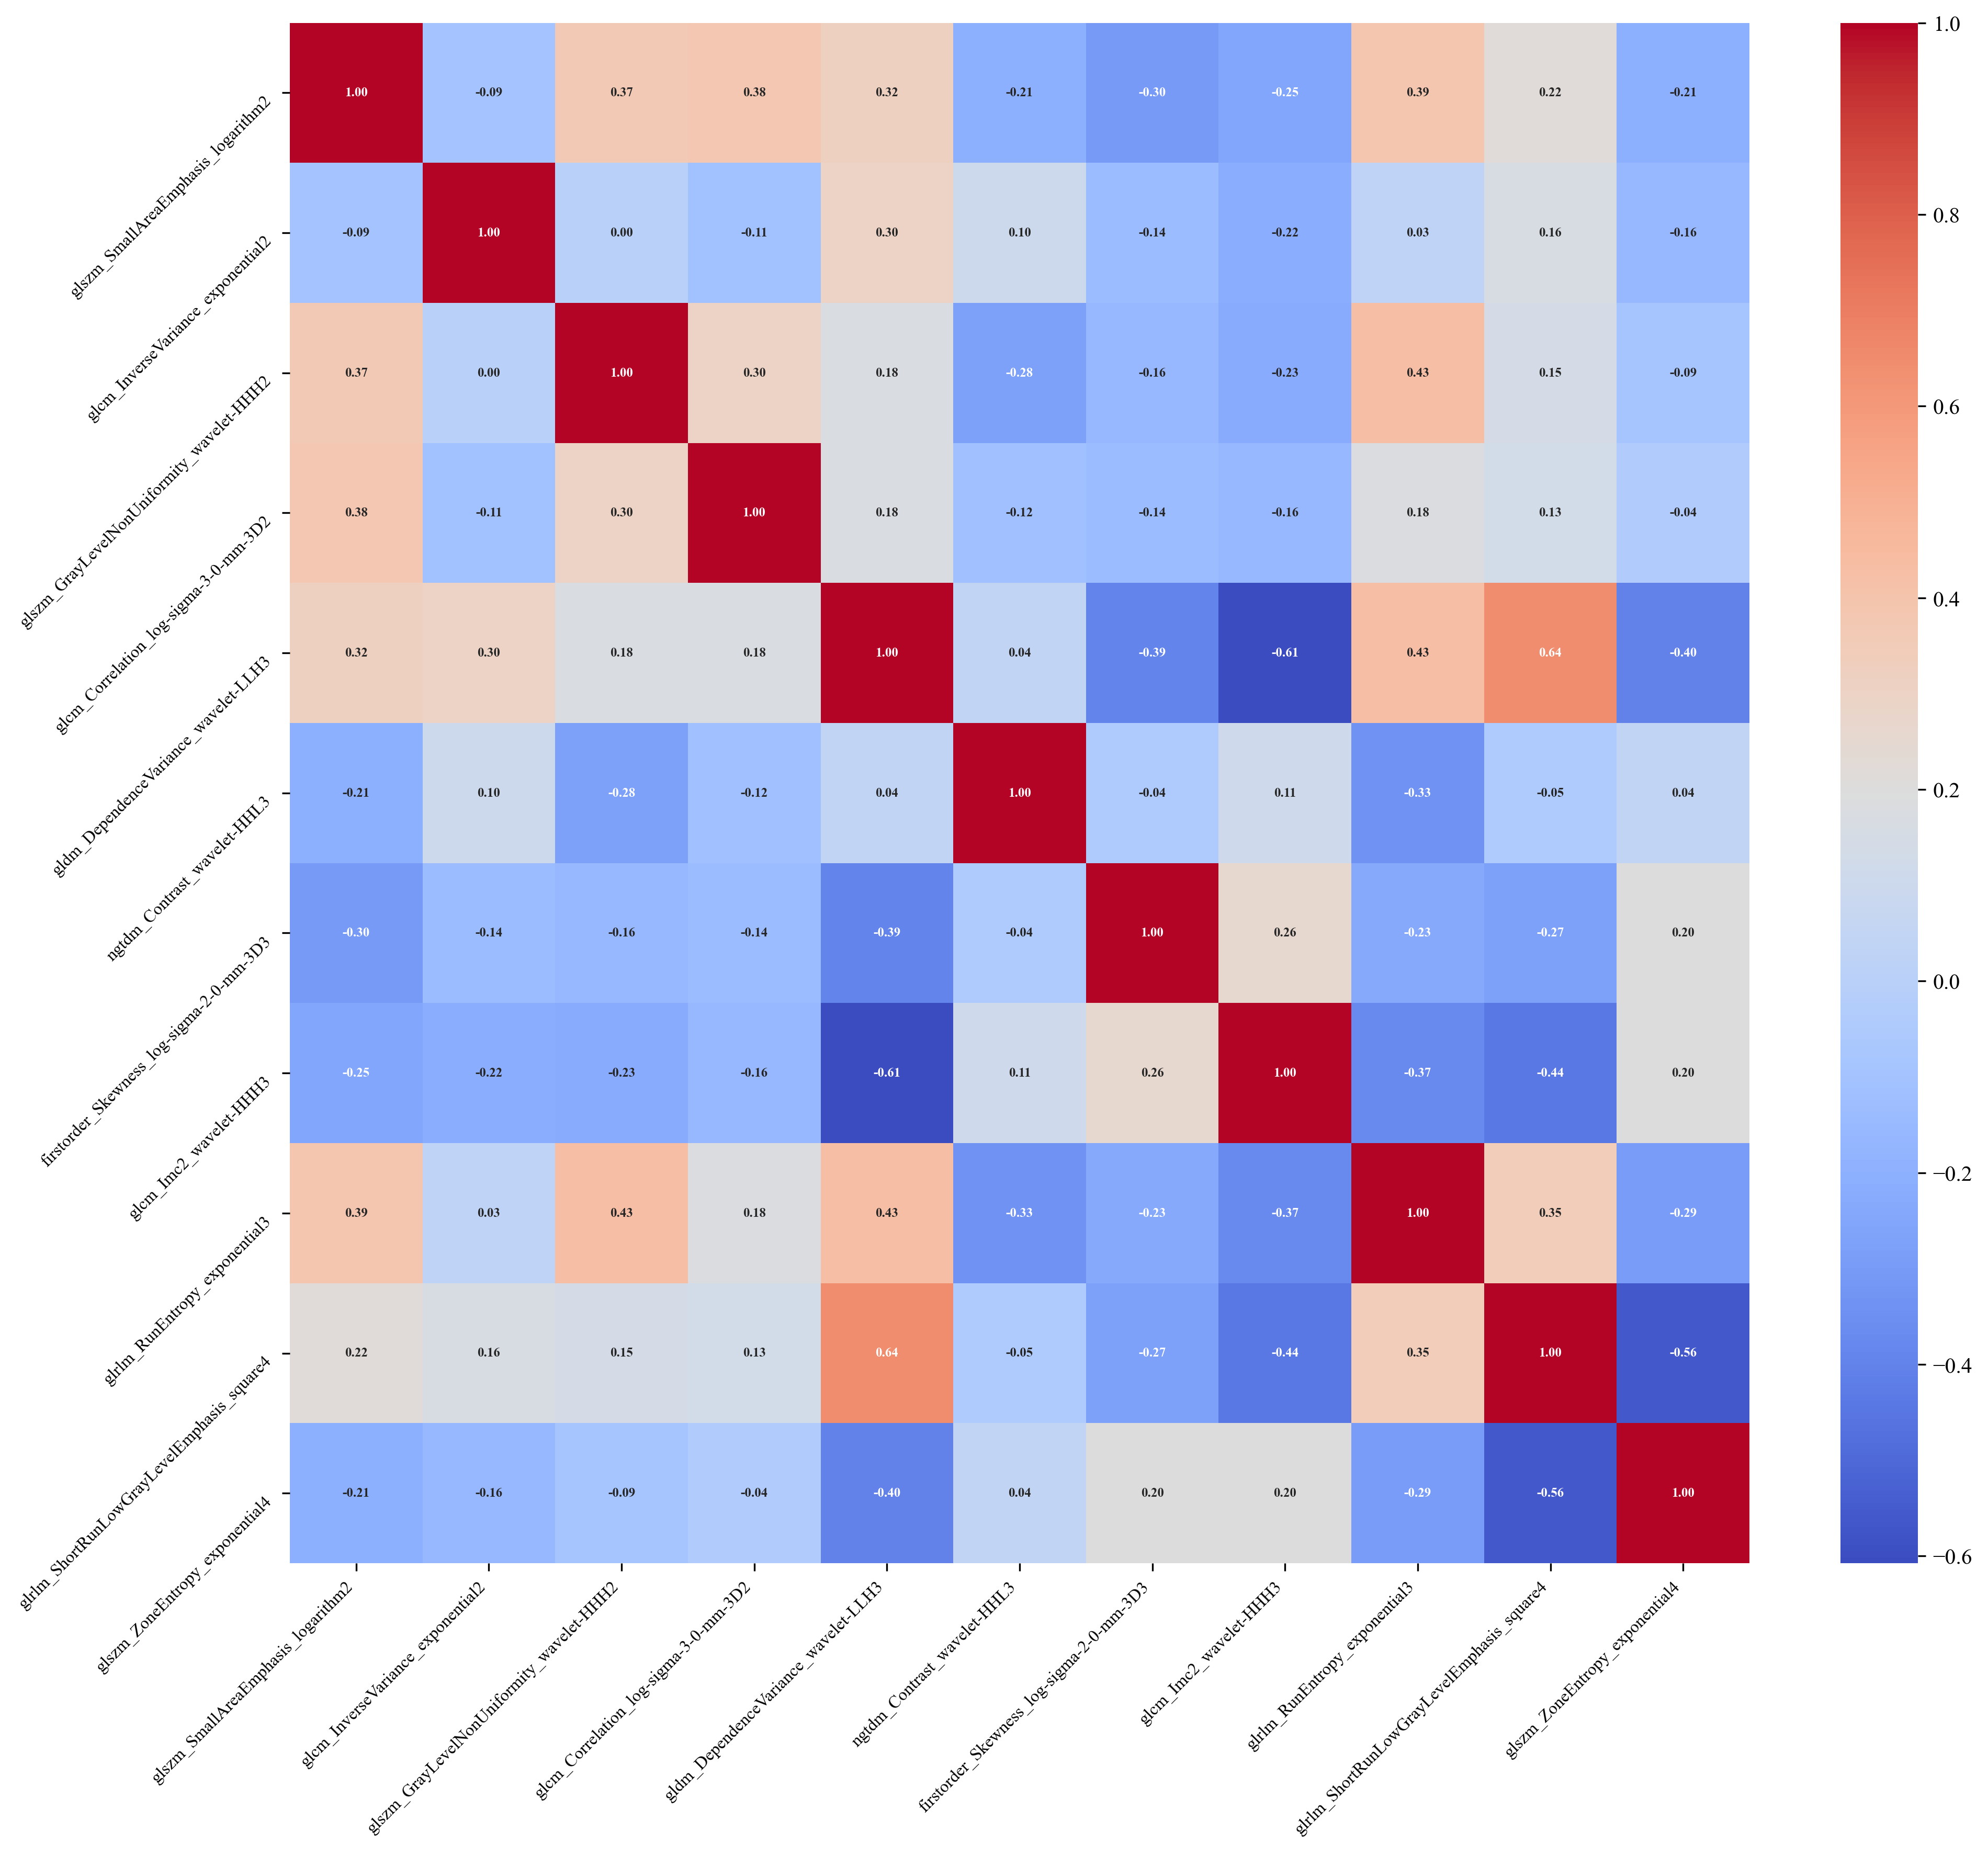

In [490]:
# 绘制特征相关系数热力图
# The fusion features
hemp_df = lasso_df.iloc[:,2:]
f, ax= plt.subplots(figsize = (15, 13),dpi=300)
sns.heatmap(hemp_df.corr(),annot=True,fmt='.2f',cmap='coolwarm',annot_kws={'size':6,'weight':'bold', },ax=ax)#绘制混淆矩阵
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'size':8}, rotation=45,va="top",ha="right")
ax.set_yticklabels(ax.get_yticklabels(), fontdict={'size':8}, rotation=45, va='top', ha='right')
plt.savefig('fusion_hempmap.png',dpi=300)
plt.show()

========== Total 1 labeled mask ==========


<Figure size 432x288 with 0 Axes>

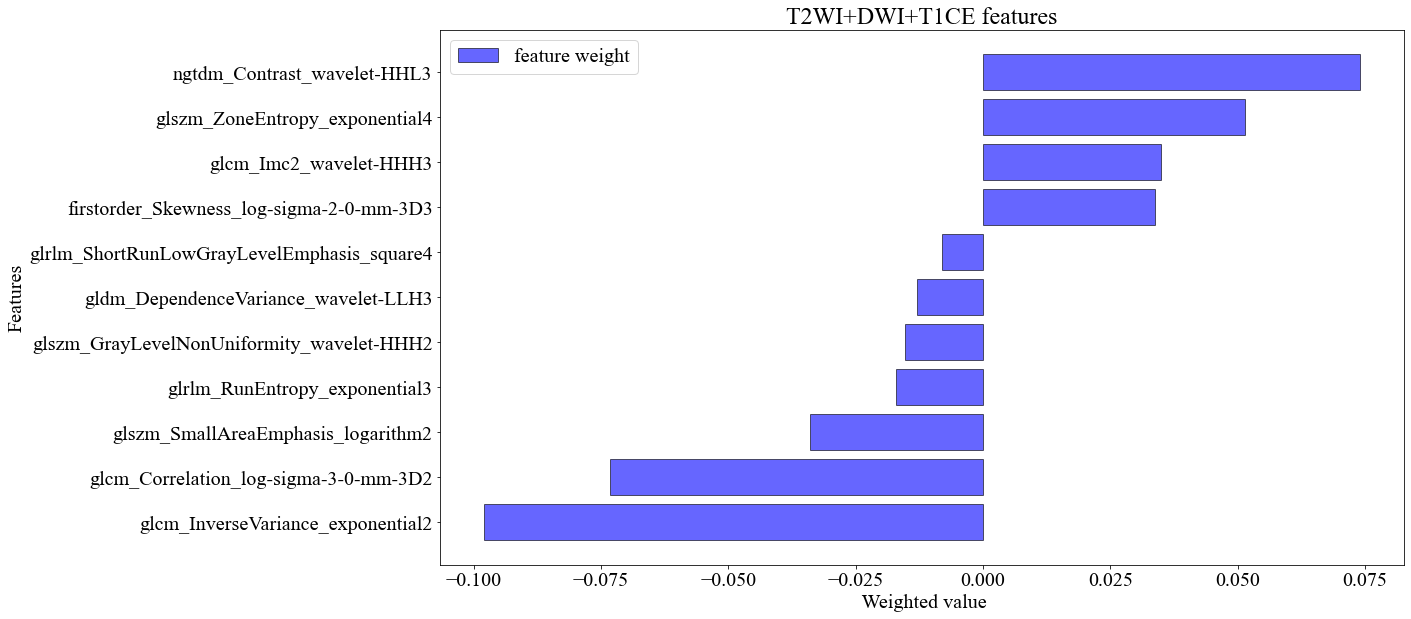

In [491]:
plt.rc('font',family='Times New Roman') # rc方式设置字体
# Sci paper一般选用Arial格式或者Times New Roman 格式
plt.rcParams['font.family'] = 'Times New Roman' # 设置字体样式
plt.rcParams['font.size'] = '20' # 设置字体大小

#绘制误差棒图
plt.clf()
subfig_num = 1
print('='*10, f'Total {subfig_num} labeled mask', '='*10)	
title_list = ['T2WI', 'DWI', 'T1CE']
col = 1	# 设置子图列数
row = subfig_num//col 	# 通过子图数量和列数计算子图行数
if subfig_num%col > 0:
    row += 1
nfig = 0
fig, ax = plt.subplots(1, 1, figsize=(20, int(9*row/col)))  # 通过"sharex='col', sharey='row'"参数设置共享行列坐标轴
#画一个特征系数的柱状图
coefs = lassoCV_model.coef_
coefs = coefs[coefs != 0]
coefs = pd.Series(coefs, index=lasso_df.drop(clin_cols, axis=1).columns)
weight = coefs[coefs != 0].to_dict()
#根据值大小排列一下
weight = dict(sorted(weight.items(),key=lambda x:x[1],reverse=False))
ax.set_title(f'T2WI+DWI+T1CE features')#标题，并设定字号大小
ax.set_xlabel(f' Weighted value')#设置x轴，并设定字号大小
ax.set_ylabel(u'Features')
ax.barh(range(len(weight.values())), list(weight.values()),tick_label = list(weight.keys()),alpha=0.6, facecolor = 'blue', edgecolor = 'black', label='feature weight')
ax.legend(loc=0)#图例展示位置，数字代表第几象限
plt.tight_layout() # 防止标题重叠
plt.savefig(os.path.join(imgdir, 'ASM_features_weight.png'), dpi=300)
plt.show()

========== Total 1 labeled mask ==========


<Figure size 432x288 with 0 Axes>

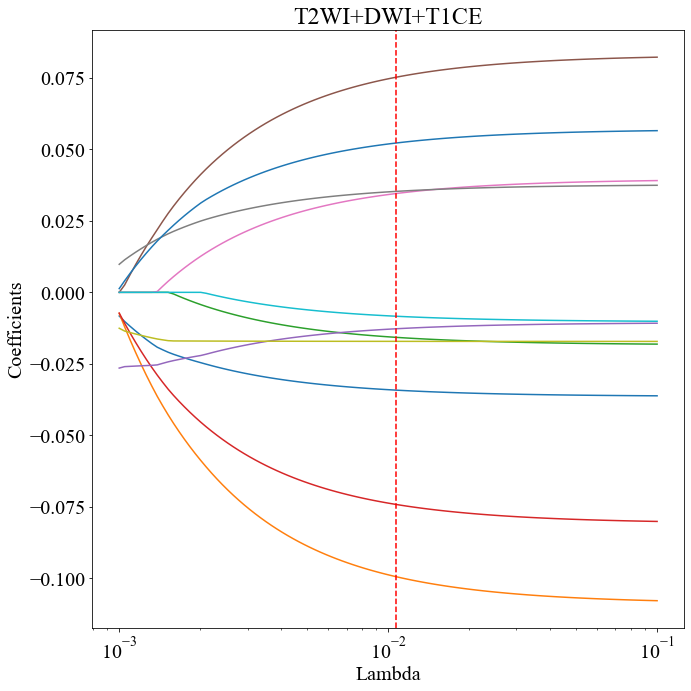

In [492]:
#这个图显示随着lambda的变化，系数的变化走势
from sklearn import linear_model
plt.rc('font',family='Times New Roman') # rc方式设置字体
# Sci paper一般选用Arial格式或者Times New Roman 格式
plt.rcParams['font.family'] = 'Times New Roman' # 设置字体样式
plt.rcParams['font.size'] = '20' # 设置字体大小

#绘制误差棒图
plt.clf()
subfig_num = 1
print('='*10, f'Total {subfig_num} labeled mask', '='*10)	
title_list = ['T2WI', 'DWI', 'T1CE']
col = 3	# 设置子图列数
row = subfig_num//col 	# 通过子图数量和列数计算子图行数
if subfig_num%col > 0:
    row += 1
nfig = 0
fig, ax = plt.subplots(1, 1, figsize=(10,10))  # 通过"sharex='col', sharey='row'"参数设置共享行列坐标轴
lassoCV_x = lasso_df.drop(tag_cols1, axis=1)
lassoCV_y = lasso_df['label']
alpha_range = np.logspace(-3, -1, 100, base=10)
# 使用path的到alphas_,并不会影响之前训练的最优alpha_和coef_的值
coefs = lassoCV_model.path(lassoCV_x,lassoCV_y, alphas=alpha_range, max_iter=10000)[1].T
ax.semilogx(lassoCV_model.alphas,coefs,'-')
ax.axvline(lassoCV_model.alpha_ , color='red', ls='--')  #dual_gap_
ax.set_xlabel('Lambda')
ax.set_ylabel('Coefficients')
ax.set_title('T2WI+DWI+T1CE')
nfig += 1
    
plt.tight_layout() # 防止标题重叠
plt.savefig(os.path.join(imgdir, 'ASM_lasso_coefs.png'), dpi=300)
plt.show()

#### ASM mRMR

In [493]:
# create some pandas data
df = pd.read_csv(os.path.join(datadir, 'ASM_feas_lasso_sel.csv'))
# Scale the features since lasso used the scaled value.
X = df.drop(tag_cols1, axis=1)
Y = df['label']
sel_col = mrmr_classif(X, Y, 20)
sel_col = tag_cols1+sel_col
mrmr_df = df[sel_col]
info="筛选后剩下的特征数：{}个".format(len(sel_col)-len(tag_cols1))
wprint(info)                   
mrmr_df.to_csv(os.path.join(datadir,'ASM_mrmr_feas.csv'), index=0)
ASM_df = mrmr_df
feas_list = df.columns.to_list()
feas_list

100%|██████████| 11/11 [00:03<00:00,  3.32it/s]

=                      筛选后剩下的特征数：11个                       =


['pid',
 'label',
 'glszm_SmallAreaEmphasis_logarithm2',
 'glcm_InverseVariance_exponential2',
 'glszm_GrayLevelNonUniformity_wavelet-HHH2',
 'glcm_Correlation_log-sigma-3-0-mm-3D2',
 'gldm_DependenceVariance_wavelet-LLH3',
 'ngtdm_Contrast_wavelet-HHL3',
 'firstorder_Skewness_log-sigma-2-0-mm-3D3',
 'glcm_Imc2_wavelet-HHH3',
 'glrlm_RunEntropy_exponential3',
 'glrlm_ShortRunLowGrayLevelEmphasis_square4',
 'glszm_ZoneEntropy_exponential4']

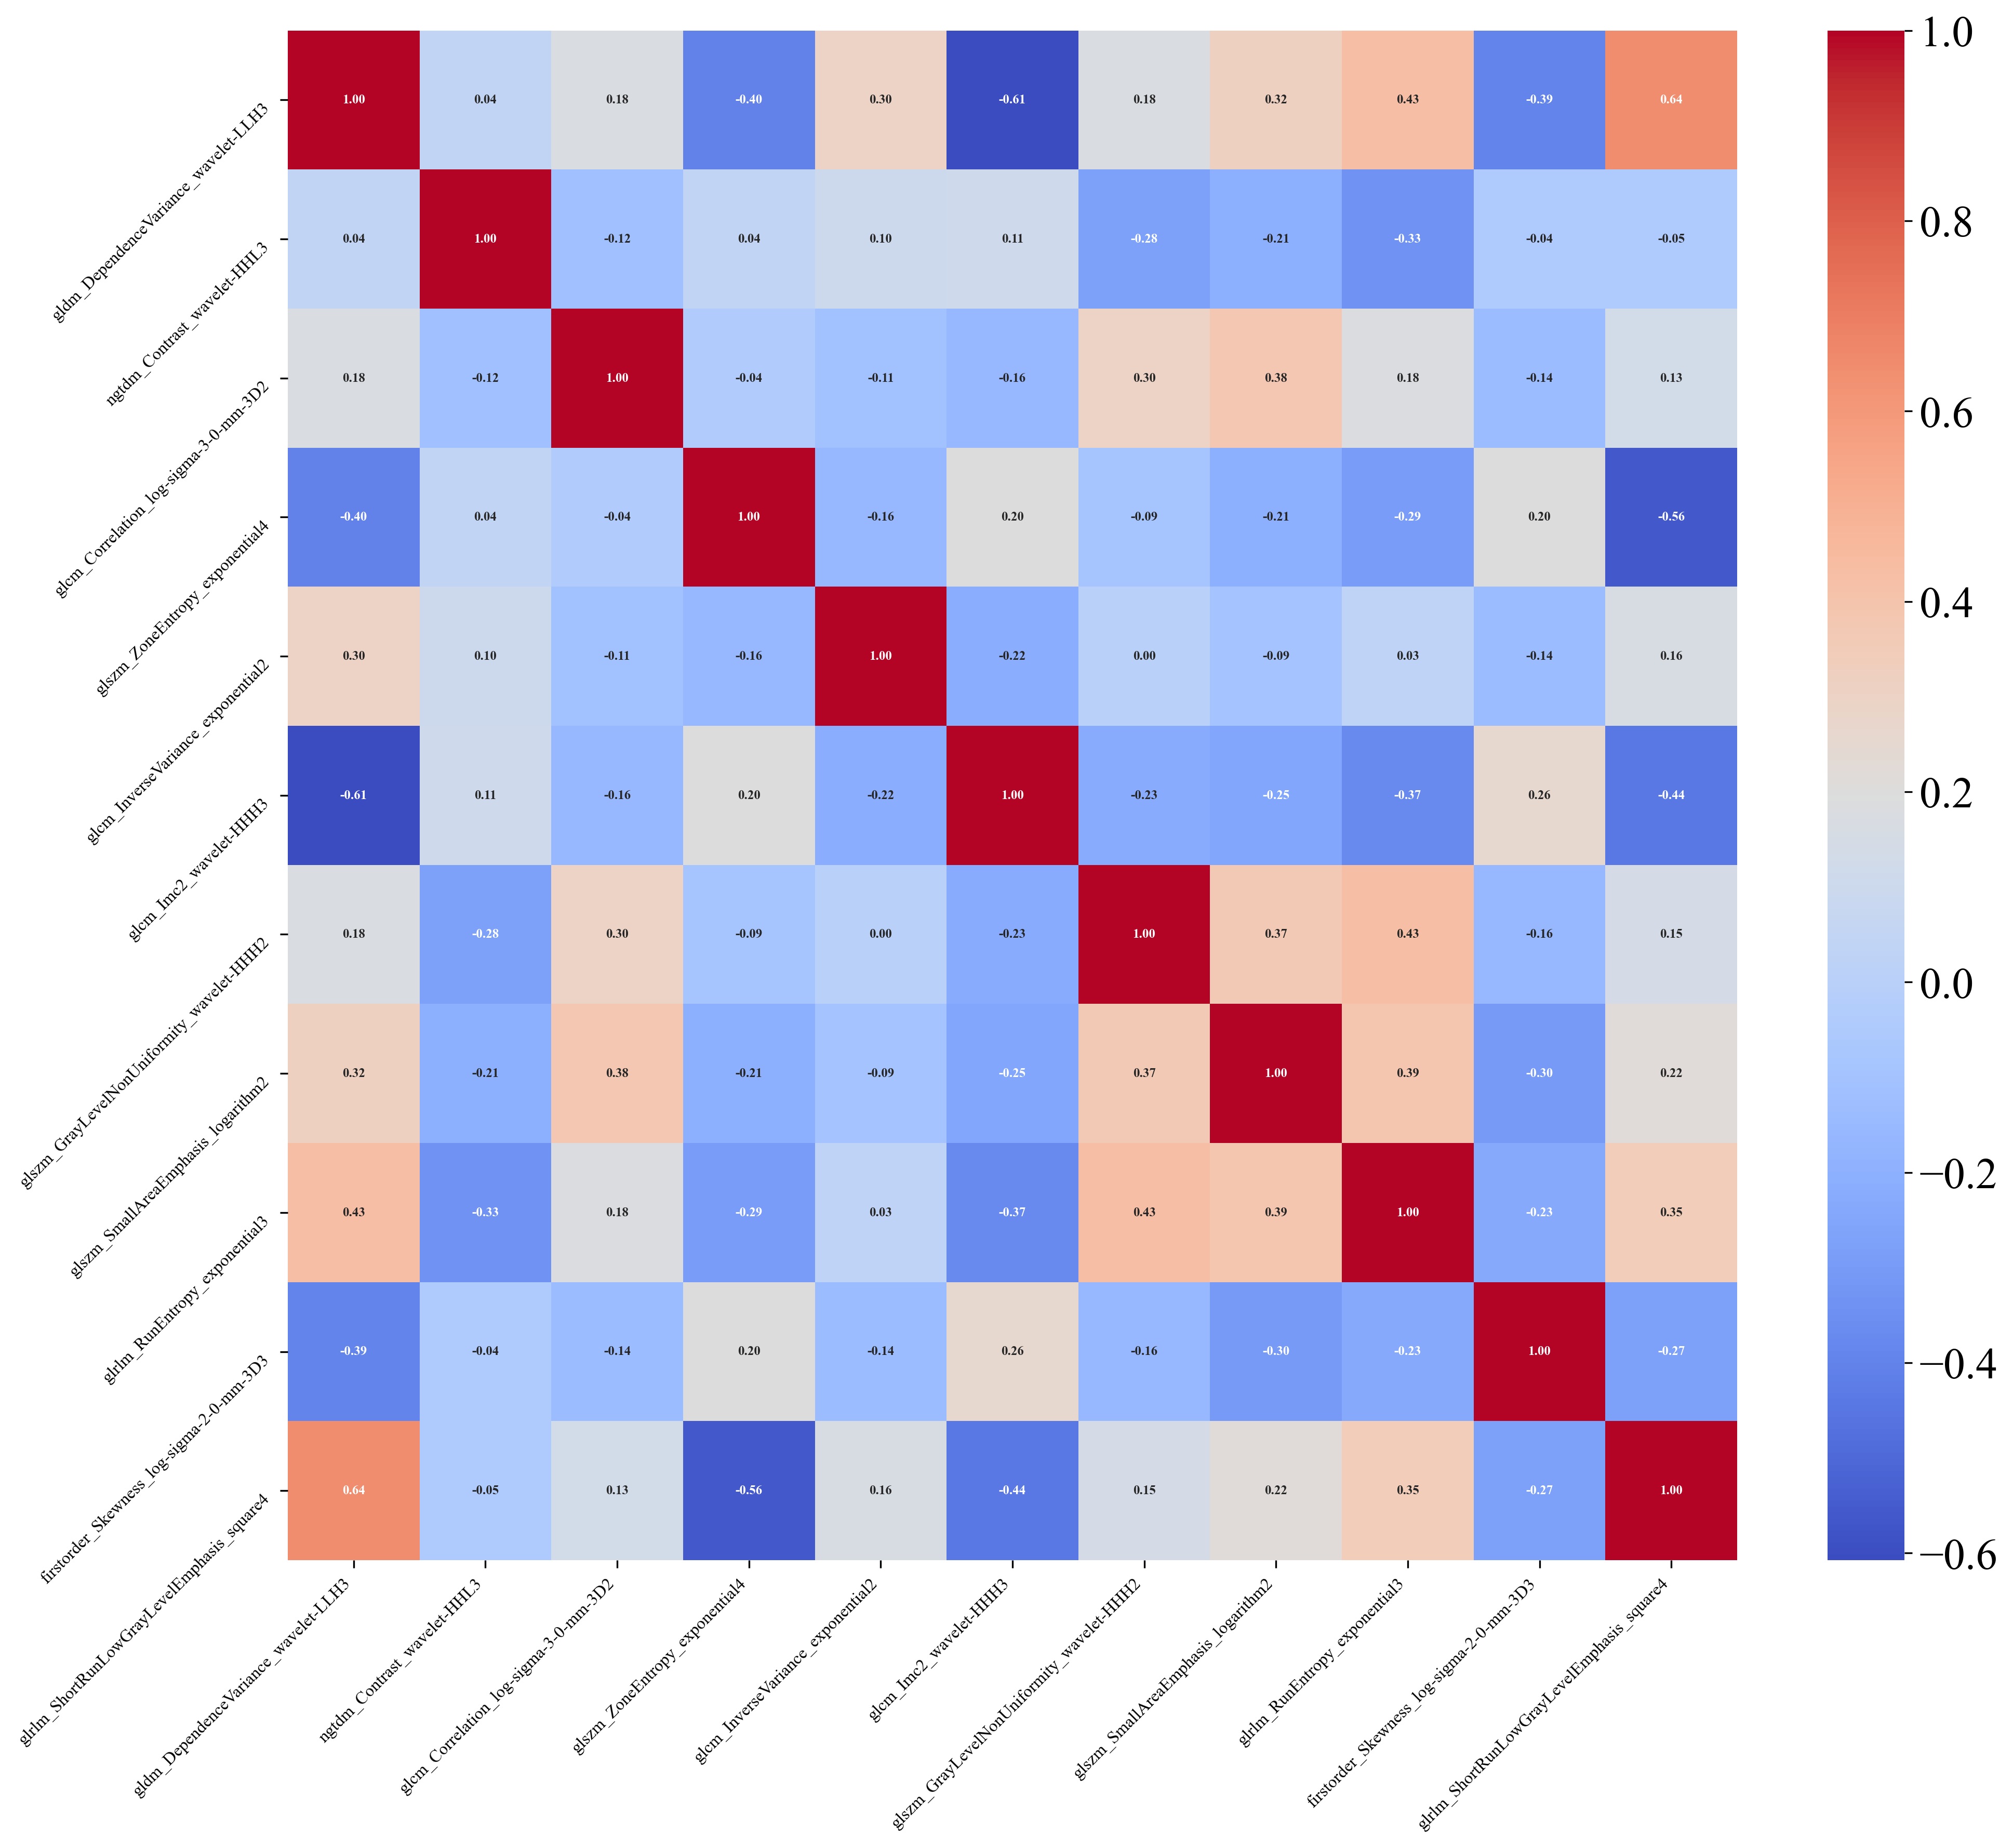

In [494]:
# 绘制特征相关系数热力图
# The fusion features
hemp_df = mrmr_df.iloc[:,2:]
f, ax= plt.subplots(figsize = (15, 13),dpi=300)
sns.heatmap(hemp_df.corr(),annot=True,fmt='.2f',cmap='coolwarm',annot_kws={'size':6,'weight':'bold', },ax=ax)#绘制混淆矩阵
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'size':8}, rotation=45,va="top",ha="right")
ax.set_yticklabels(ax.get_yticklabels(), fontdict={'size':8}, rotation=45, va='top', ha='right')
plt.savefig(os.path.join(imgdir, 'ASM_heatmap.png'),dpi=300)
plt.show()

#### DSM and ASM corr

========== Total 2 labeled mask ==========


<Figure size 432x288 with 0 Axes>

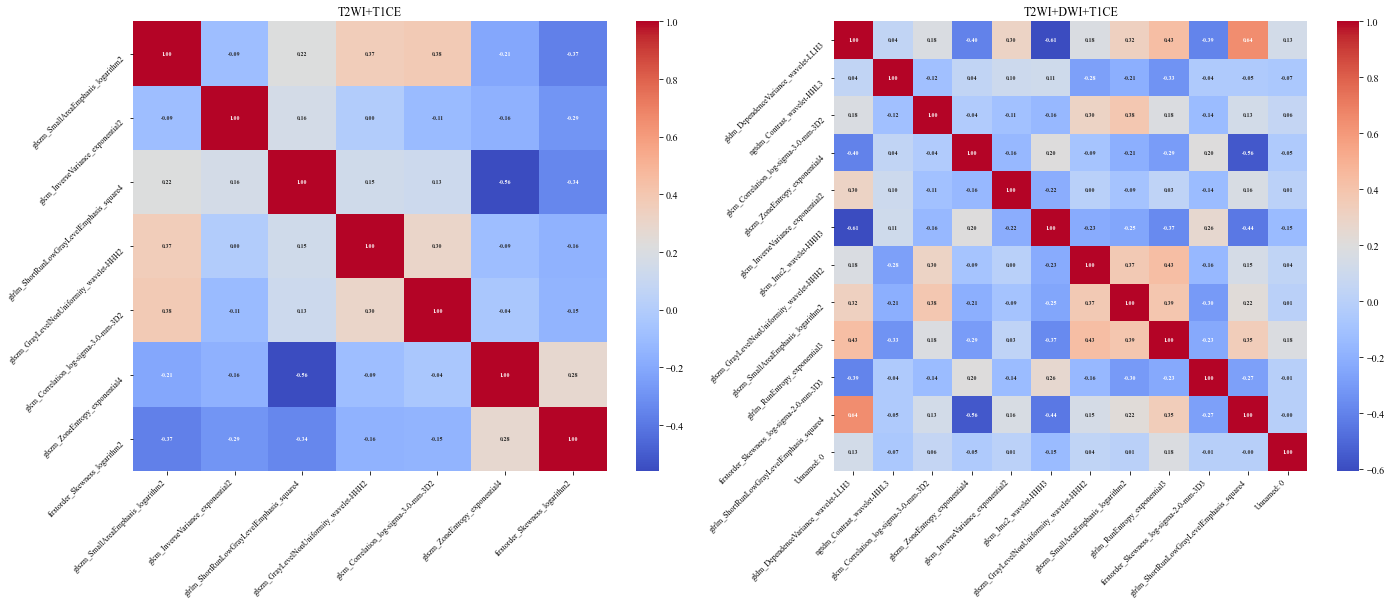

In [262]:
plt.rc('font',family='Times New Roman') # rc方式设置字体
# Sci paper一般选用Arial格式或者Times New Roman 格式
plt.rcParams['font.family'] = 'Times New Roman' # 设置字体样式
plt.rcParams['font.size'] = '10' # 设置字体大小

DA_list = [DSM_slit[1], ASM_df]
#绘制误差棒图
plt.clf()
subfig_num = len(DA_list)
print('='*10, f'Total {subfig_num} labeled mask', '='*10)	
title_list = ['T2WI+T1CE', 'T2WI+DWI+T1CE']
col = 2	# 设置子图列数
row = subfig_num//col 	# 通过子图数量和列数计算子图行数
if subfig_num%col > 0:
    row += 1
nfig = 0
fig, ax = plt.subplots(row, col, figsize=(20,17*row/col))  # 通过"sharex='col', sharey='row'"参数设置共享行列坐标轴
# 将ax统一成二维数组
if row == 1:
    ax = np.array([ax])
for i in range(len(DA_list)):
    # The fusion features
    hemp_df = DA_list[i].iloc[:,2:]
    sns.heatmap(hemp_df.corr(),annot=True,fmt='.2f',cmap='coolwarm',annot_kws={'size':6,'weight':'bold', },ax=ax[nfig//col, nfig%col])#绘制混淆矩阵
    ax[nfig//col, nfig%col].set_xticklabels(ax[nfig//col, nfig%col].get_xticklabels(), fontdict={'size':8}, rotation=45,va="top",ha="right")
    ax[nfig//col, nfig%col].set_yticklabels(ax[nfig//col, nfig%col].get_yticklabels(), fontdict={'size':8}, rotation=45, va='top', ha='right')
    ax[nfig//col, nfig%col].set_title(title_list[i])
    nfig += 1
# 去除未使用的子图边框
for i in range(subfig_num, row*col):
    ax[i//col, i%col].axis('off')
plt.tight_layout() # 防止标题重叠
plt.savefig(os.path.join(imgdir, 'DSM_ASM_heatmap.png'), dpi=300)
plt.show()

### (9) 临床特征

In [566]:
# 临床特征查看验证标签
clinical_df = pd.read_csv('../DataPreprocess/dataset_info/clinical_data.csv')
clinical_df = features_preprocess(clinical_df)
clinical_df = features_norm(clinical_df)
clinical_df = clinical_df[[ 'pid', 'label', 'age', 
       'diaphram_nodule', 'relationship_on_T1_dual_echo_images',
       'mass_feature','LDH', 'NLR', 'CA125', 'unilateral_or_bilateral', 
       'peritoneum_mesentery_nodules', 'parenchymal_organs', 'HE4',
       'ASA', 'ascites_amount']]
compare_list = pd.read_excel(os.path.join(datadir, 'feas_scale.xlsx'), sheet_name='sequence2')
train_num = len(compare_list)
clinical_df = df_added(clinical_df, compare_list, index='pid', add_cols=['label'], how='inner')
consis_label_num =(clinical_df['label_x']==clinical_df['label_y']).sum()
if consis_label_num == train_num:
    wprint('Clinical features consistent with radiomics')
else:
    wprint('Clinical features not consistent with radiomics, please cheak!!!')
clinical_df.insert(1, 'label', clinical_df['label_x'])
clinical_df = clinical_df.drop(['label_x', 'label_y'], axis=1)

clinical_df = features_preprocess(clinical_df) 
clinical_df = features_norm(clinical_df) 
clinical_df.to_csv(os.path.join(datadir, 'clinical_feas.csv'), index=0)
info = f'Clinical features\' number: {clinical_df.shape[1]-2}'
wprint(info)
clinical_df.columns
clinical_df.describe()

=       Clinical features consistent with radiomics        =
=              Clinical features' number: 13               =


pid       label           age  diaphram_nodule  \
count  158.000000  158.000000  1.580000e+02       158.000000   
mean   116.550633    0.651899 -7.026728e-19         0.253165   
std     68.790881    0.477883  1.003180e+00         0.436207   
min      1.000000    0.000000 -2.806662e+00         0.000000   
25%     53.250000    0.000000 -6.167725e-01         0.000000   
50%    118.500000    1.000000 -6.930029e-02         0.000000   
75%    175.750000    1.000000  5.876664e-01         0.750000   
max    235.000000    1.000000  2.449072e+00         1.000000   

       relationship_on_T1_dual_echo_images  mass_feature           LDH  \
count                           158.000000    158.000000  1.580000e+02   
mean                              1.740506      2.329114  1.159410e-17   
std                               1.059866      0.785563  1.003180e+00   
min                               0.000000      1.000000 -1.202434e+00   
25%                               1.000000      2.000000 -5.212775e-01   
50%                               2.000000      3.000000 -3.258107e-01   
75%                               3.000000      3.000000  1.238642e-01   
max                               3.000000      3.000000  7.296381e+00   

                NLR         CA125  unilateral_or_bilateral  \
count  1.580000e+02  1.580000e+02               158.000000   
mean  -8.432074e-18  6.324055e-18                 1.544304   
std    1.003180e+00  1.003180e+00                 0.499617   
min   -1.444844e+00 -6.226793e-01                 1.000000   
25%   -7.026420e-01 -5.357474e-01                 1.000000   
50%   -3.153231e-01 -3.537746e-01                 2.000000   
75%    4.354651e-01  1.141483e-01                 2.000000   
max    4.546197e+00  8.508225e+00                 2.000000   

       peritoneum_mesentery_nodules  parenchymal_organs           HE4  \
count                    158.000000          158.000000  1.580000e+02   
mean                       0.721519            0.069620 -9.837419e-18   
std                        0.449677            0.255315  1.003180e+00   
min                        0.000000            0.000000 -5.885402e-01   
25%                        0.000000            0.000000 -4.928630e-01   
50%                        1.000000            0.000000 -3.028820e-01   
75%                        1.000000            0.000000  3.015706e-02   
max                        1.000000            1.000000  6.831249e+00   

              ASA  ascites_amount  
count  158.000000      158.000000  
mean     2.234177        1.626582  
std      0.424830        0.485250  
min      2.000000        1.000000  
25%      2.000000        1.000000  
50%      2.000000        2.000000  
75%      2.000000        2.000000  
max      3.000000        2.000000

In [538]:
print(len(clinical_df))

158


In [567]:
# T-test for clinical feas.
clin_cols = ['pid', 'label']
clinical_df = pd.read_csv(os.path.join(datadir, 'clinical_feas.csv'))
ttest_sel_cols = feas_sel_ttest(clinical_df)
clinical_df = clinical_df[clin_cols+ ttest_sel_cols+['CA125']]
info = f'{clinical_df.shape[1]-len(clin_cols)} features selected for clinical features'
wprint(info)
clinical_df.to_csv(os.path.join(datadir, 'clinical_feas_ttest_sel.csv'), index=0)
clinical_df.columns
clinical_df.describe()

=        10 features selected for clinical features        =


pid       label  diaphram_nodule  \
count  158.000000  158.000000       158.000000   
mean   116.550633    0.651899         0.253165   
std     68.790881    0.477883         0.436207   
min      1.000000    0.000000         0.000000   
25%     53.250000    0.000000         0.000000   
50%    118.500000    1.000000         0.000000   
75%    175.750000    1.000000         0.750000   
max    235.000000    1.000000         1.000000   

       relationship_on_T1_dual_echo_images  mass_feature           LDH  \
count                           158.000000    158.000000  1.580000e+02   
mean                              1.740506      2.329114  1.264811e-17   
std                               1.059866      0.785563  1.003180e+00   
min                               0.000000      1.000000 -1.202434e+00   
25%                               1.000000      2.000000 -5.212775e-01   
50%                               2.000000      3.000000 -3.258107e-01   
75%                               3.000000      3.000000  1.238642e-01   
max                               3.000000      3.000000  7.296381e+00   

                NLR  peritoneum_mesentery_nodules  parenchymal_organs  \
count  1.580000e+02                    158.000000          158.000000   
mean  -9.134746e-18                      0.721519            0.069620   
std    1.003180e+00                      0.449677            0.255315   
min   -1.444844e+00                      0.000000            0.000000   
25%   -7.026420e-01                      0.000000            0.000000   
50%   -3.153231e-01                      1.000000            0.000000   
75%    4.354651e-01                      1.000000            0.000000   
max    4.546197e+00                      1.000000            1.000000   

                HE4  ascites_amount         CA125  
count  1.580000e+02      158.000000  1.580000e+02  
mean  -8.432074e-18        1.626582  3.021493e-17  
std    1.003180e+00        0.485250  1.003180e+00  
min   -5.885402e-01        1.000000 -6.226793e-01  
25%   -4.928630e-01        1.000000 -5.357474e-01  
50%   -3.028820e-01        2.000000 -3.537746e-01  
75%    3.015706e-02        2.000000  1.141483e-01  
max    6.831249e+00        2.000000  8.508225e+00

In [568]:
df = pd.read_csv(os.path.join(datadir, 'clinical_feas_ttest_sel.csv'))
df = df[['pid', 'label',
        'LDH','mass_feature',  'NLR', 'diaphram_nodule','CA125',
       'parenchymal_organs', 'HE4', 'ascites_amount',
       'relationship_on_T1_dual_echo_images', 'peritoneum_mesentery_nodules',
        ]]
alphas = np.logspace(-3, -1, 100, base=10)
max_iter = 100000
lassoCV_model = feas_sel_Lasso(df, alphas=alphas, max_iter=max_iter)
feas_col = [col for col in list(df.columns) if col not in tag_cols1]
coefs = pd.Series(lassoCV_model.coef_, index=feas_col)
lasso_sel_col = tag_cols1 + list(coefs[coefs !=0].index)
clinical_df = df[lasso_sel_col+['LDH']]
clinical_df.to_csv(os.path.join(datadir,'clinical_lasso_sel.csv'), index=0)
info = f'{clinical_df.shape[1]-2} features selected for clinical features by lasso selector'
info1 = f'The best alpha value are {lassoCV_model.alpha_} for sequence clinical'
wprint(info)
wprint(info1)
feas_list = clinical_df.columns.to_list()[2:] 
print(feas_list)
lasso_sel_col

=         10 features selected for clinical features by lasso selector         =
=     The best alpha value are 0.016297508346206444 for sequence clinical      =
['mass_feature', 'NLR', 'diaphram_nodule', 'CA125', 'parenchymal_organs', 'HE4', 'ascites_amount', 'relationship_on_T1_dual_echo_images', 'peritoneum_mesentery_nodules', 'LDH']


['pid',
 'label',
 'mass_feature',
 'NLR',
 'diaphram_nodule',
 'CA125',
 'parenchymal_organs',
 'HE4',
 'ascites_amount',
 'relationship_on_T1_dual_echo_images',
 'peritoneum_mesentery_nodules']

========== Total 1 labeled mask ==========


<Figure size 432x288 with 0 Axes>

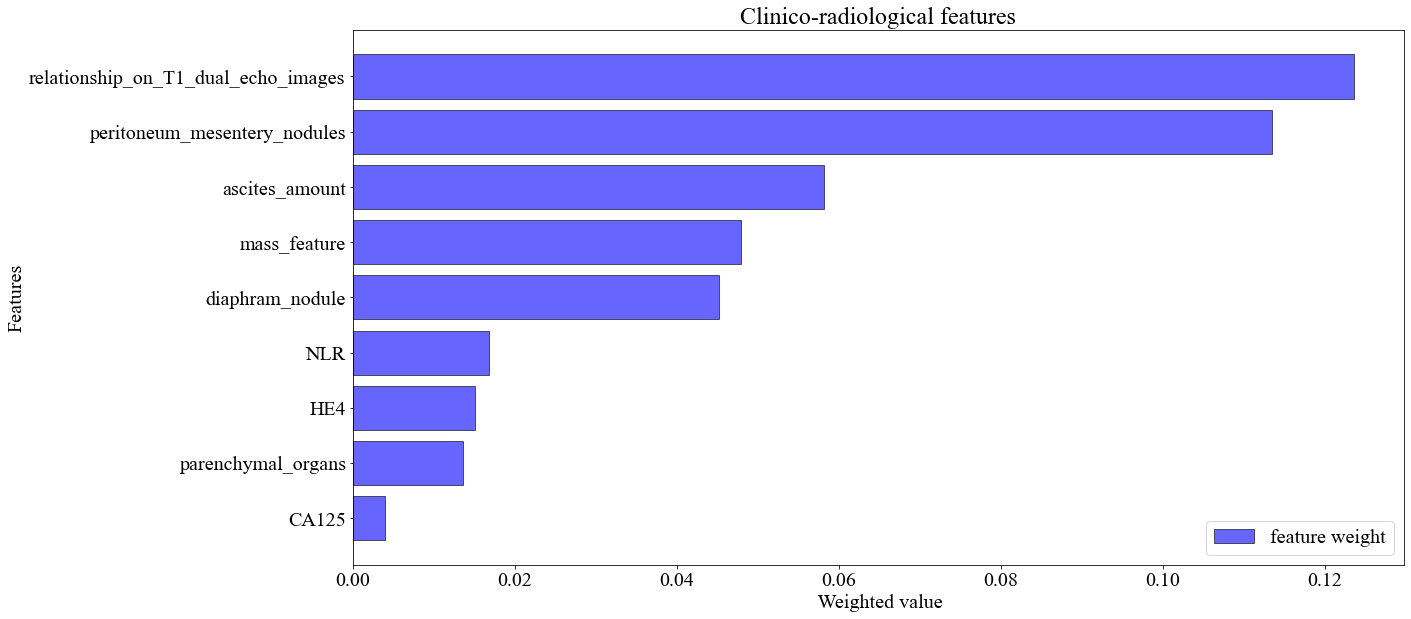

In [569]:
plt.rc('font',family='Times New Roman') # rc方式设置字体
# Sci paper一般选用Arial格式或者Times New Roman 格式
plt.rcParams['font.family'] = 'Times New Roman' # 设置字体样式
plt.rcParams['font.size'] = '20' # 设置字体大小

#绘制误差棒图
plt.clf()
subfig_num = 1
print('='*10, f'Total {subfig_num} labeled mask', '='*10)	
title_list = ['T2WI', 'DWI', 'T1CE']
col = 1	# 设置子图列数
row = subfig_num//col 	# 通过子图数量和列数计算子图行数
if subfig_num%col > 0:
    row += 1
nfig = 0
fig, ax = plt.subplots(1, 1, figsize=(20, int(9*row/col)))  # 通过"sharex='col', sharey='row'"参数设置共享行列坐标轴
#画一个特征系数的柱状图
coefs = lassoCV_model.coef_
coefs = coefs[coefs != 0]
coefs = pd.Series(coefs, index=clinical_df.drop(clin_cols+['LDH'], axis=1).columns)
weight = coefs[coefs != 0].to_dict()
#根据值大小排列一下
weight = dict(sorted(weight.items(),key=lambda x:x[1],reverse=False))
ax.set_title(f'Clinico-radiological features')#标题，并设定字号大小
ax.set_xlabel(f' Weighted value')#设置x轴，并设定字号大小
ax.set_ylabel(u'Features')
ax.barh(range(len(weight.values())), list(weight.values()),tick_label = list(weight.keys()),alpha=0.6, facecolor = 'blue', edgecolor = 'black', label='feature weight')
ax.legend(loc=0)#图例展示位置，数字代表第几象限
plt.tight_layout() # 防止标题重叠
plt.savefig(os.path.join(imgdir, 'clinico-radiological_features_weight.png'), dpi=300)
plt.show()

========== Total 1 labeled mask ==========


<Figure size 432x288 with 0 Axes>

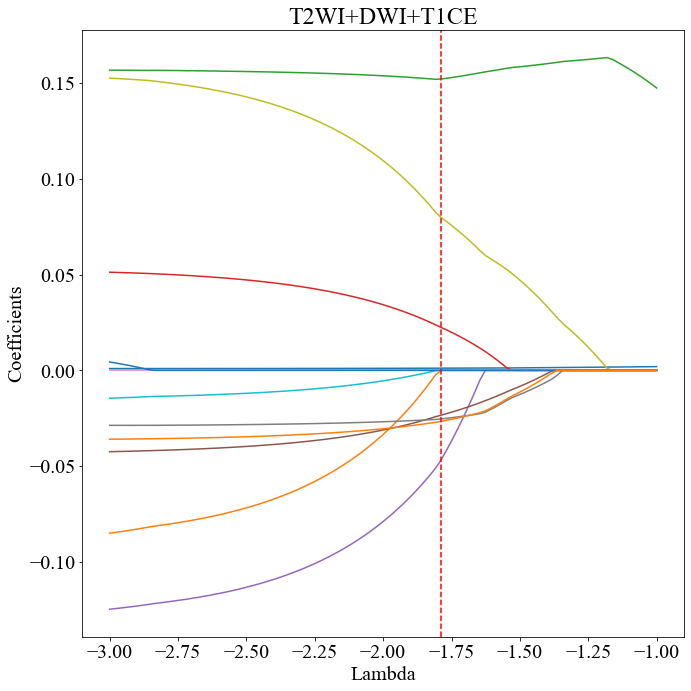

In [570]:
#这个图显示随着lambda的变化，系数的变化走势
from sklearn import linear_model
plt.rc('font',family='Times New Roman') # rc方式设置字体
# Sci paper一般选用Arial格式或者Times New Roman 格式
plt.rcParams['font.family'] = 'Times New Roman' # 设置字体样式
plt.rcParams['font.size'] = '20' # 设置字体大小

#绘制误差棒图
plt.clf()
subfig_num = 1
print('='*10, f'Total {subfig_num} labeled mask', '='*10)	
title_list = ['T2WI', 'DWI', 'T1CE']
col = 3	# 设置子图列数
row = subfig_num//col 	# 通过子图数量和列数计算子图行数
if subfig_num%col > 0:
    row += 1
nfig = 0
fig, ax = plt.subplots(1, 1, figsize=(10,10))  # 通过"sharex='col', sharey='row'"参数设置共享行列坐标轴
df = pd.read_csv(os.path.join(datadir, 'clinical_feas_ttest_sel.csv'))
lassoCV_x = df.drop(tag_cols1, axis=1)
lassoCV_x = df[lasso_sel_col+['LDH']]
lassoCV_y = lasso_df['label']
alpha_range = np.logspace(-3, -1, 100, base=10)
# 使用path的到alphas_,并不会影响之前训练的最优alpha_和coef_的值
alphas1, coefs, _ = DSM_models[1].path(lassoCV_x,lassoCV_y, alphas=alpha_range, max_iter=10000)
coefs = coefs.T
alphas1 = np.log10(alphas1)
ax.plot(alphas1,coefs,'-')
ax.axvline(np.log10(lassoCV_model.alpha_) , color='red', ls='--')  #dual_gap_
ax.set_xlabel('Lambda')
ax.set_ylabel('Coefficients')
ax.set_title('T2WI+DWI+T1CE')
nfig += 1
    
plt.tight_layout() # 防止标题重叠
plt.savefig(os.path.join(imgdir, 'Clinico-radiological_lasso_coefs.png'), dpi=300)
plt.show()

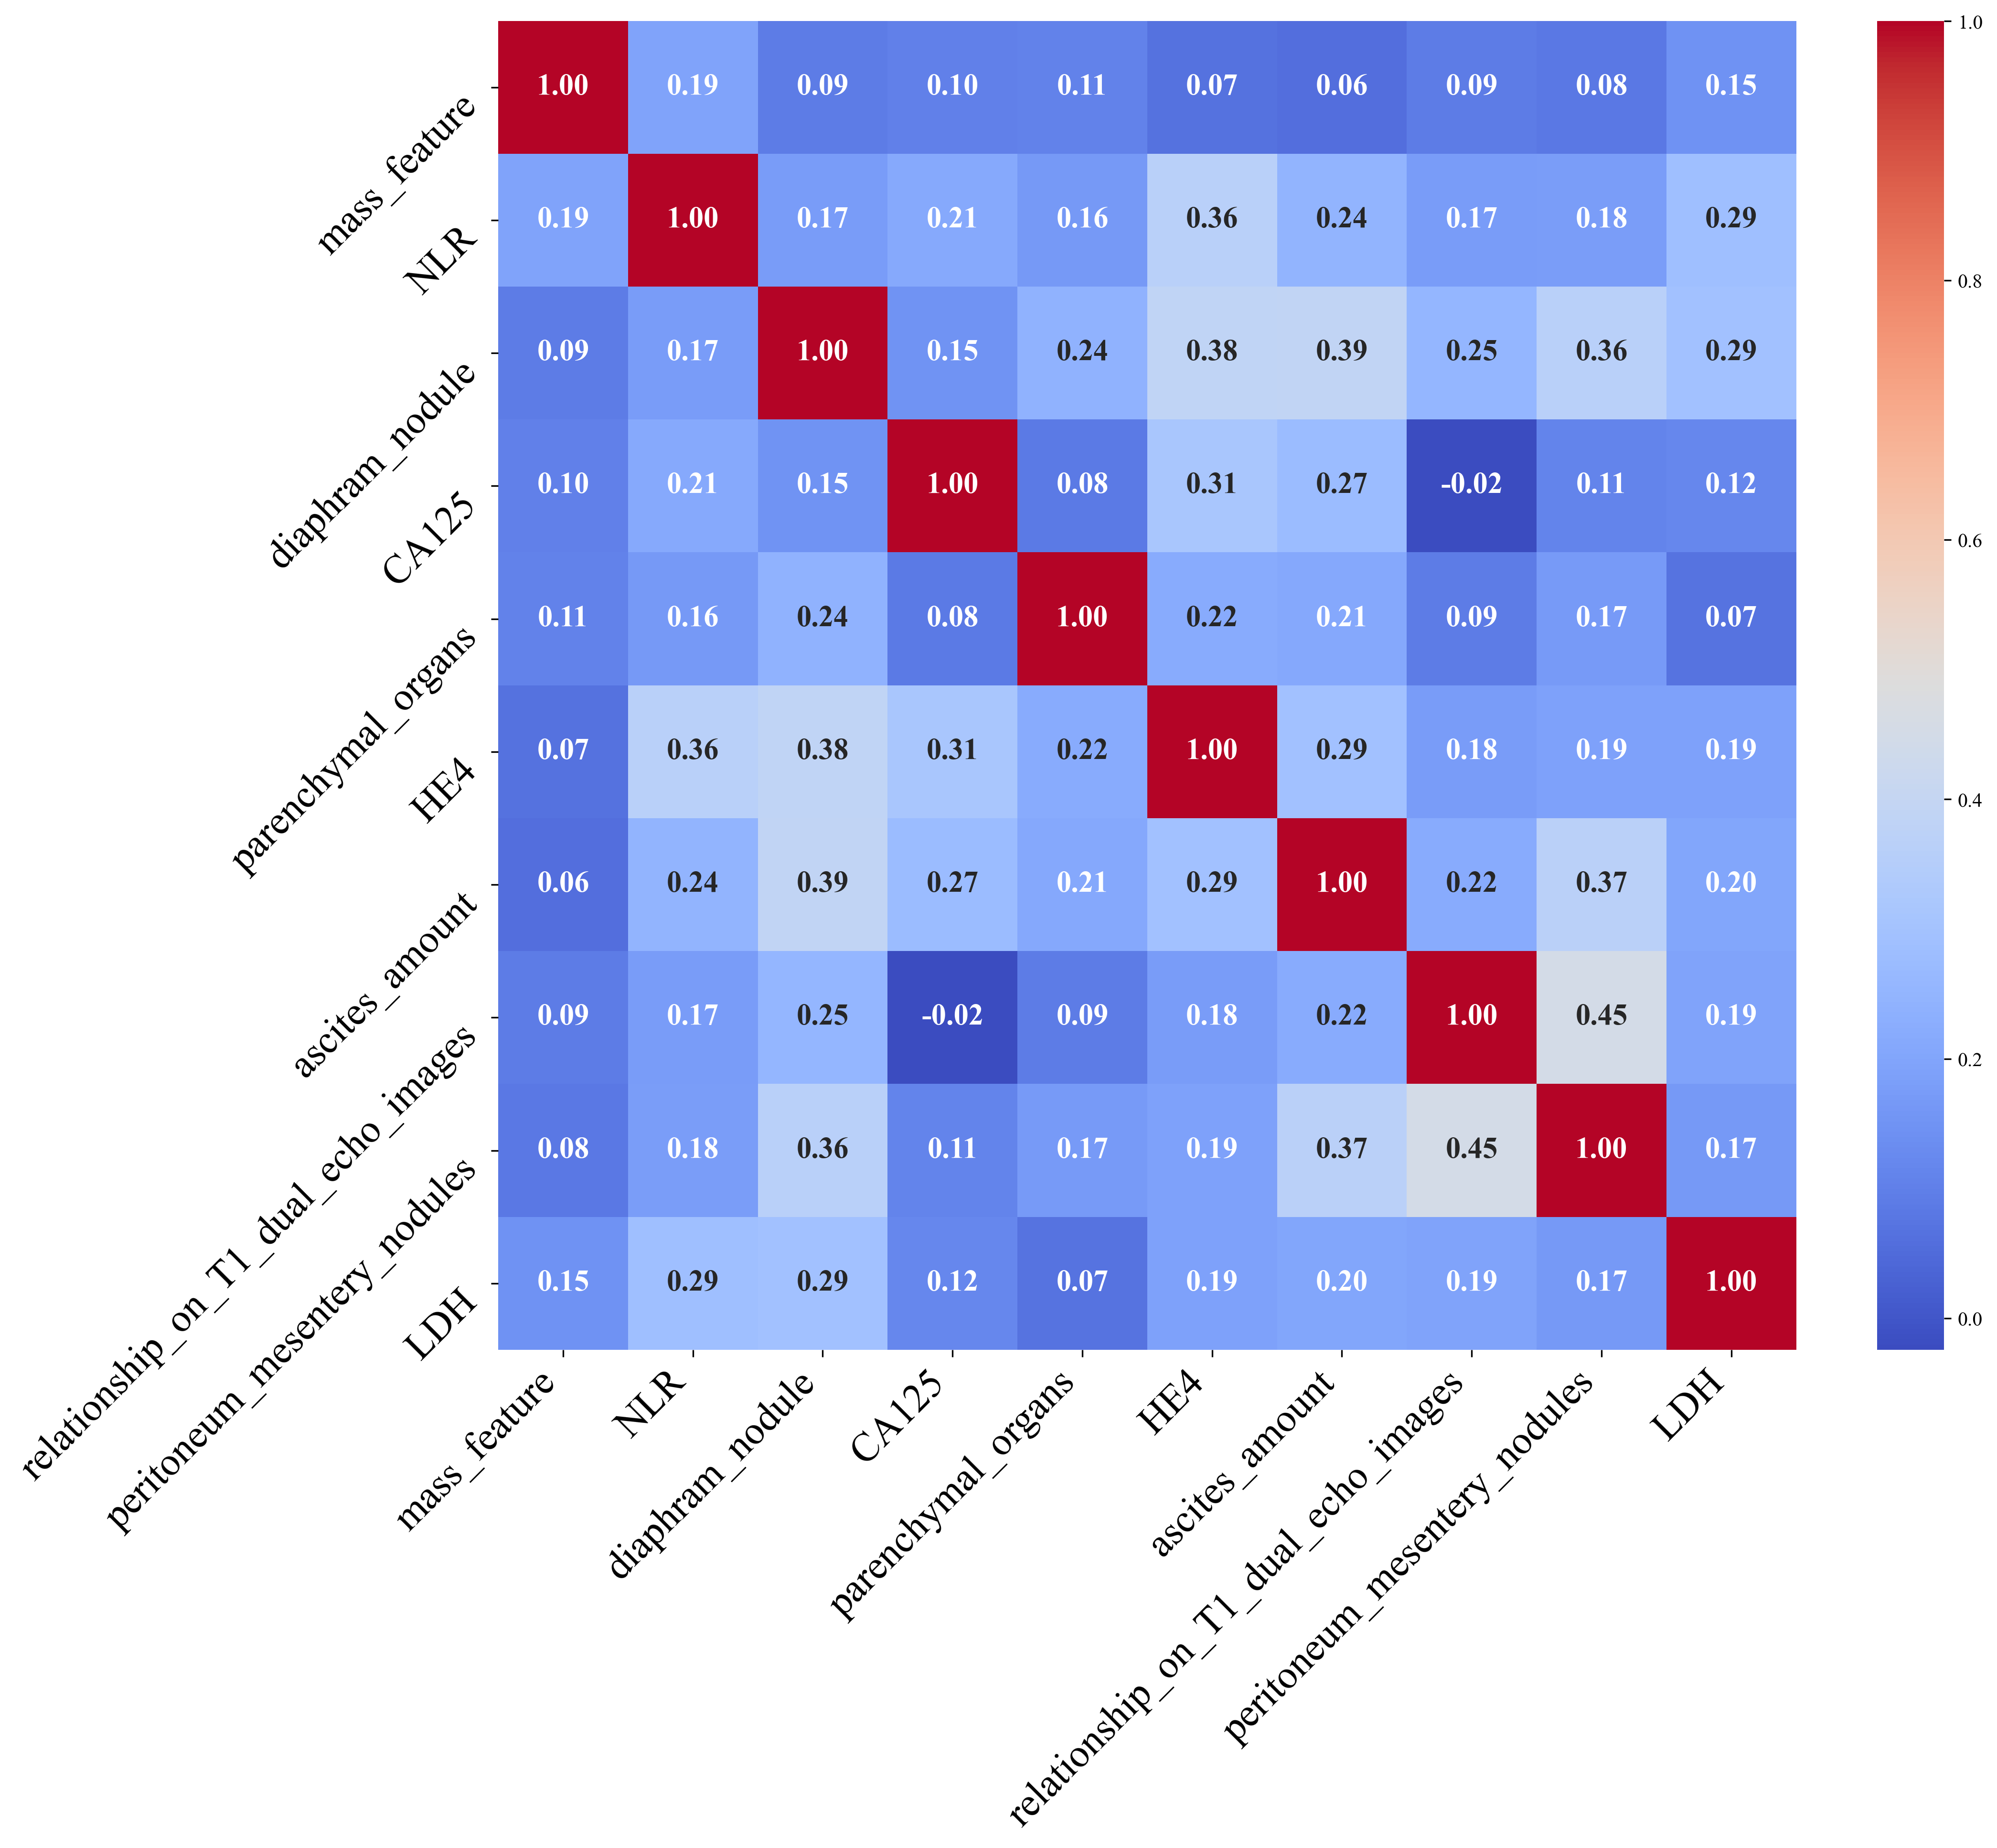

In [571]:
plt.rc('font',family='Times New Roman') # rc方式设置字体
# Sci paper一般选用Arial格式或者Times New Roman 格式
plt.rcParams['font.family'] = 'Times New Roman' # 设置字体样式
plt.rcParams['font.size'] = '10' # 设置字体大小

# 绘制特征相关系数热力图
# The fusion features
hemp_df = clinical_df.iloc[:,2:]
f, ax= plt.subplots(figsize = (15, 13),dpi=300)
sns.heatmap(hemp_df.corr(),annot=True,fmt='.2f',cmap='coolwarm',annot_kws={'size':15,'weight':'bold', },ax=ax)#绘制混淆矩阵
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'size':20}, rotation=45,va="top",ha="right")
ax.set_yticklabels(ax.get_yticklabels(), fontdict={'size':20}, rotation=45, va='top', ha='right')
plt.tight_layout() # 防止标题重叠
plt.savefig(os.path.join(imgdir,'clinico-radiological_heatmap.png'),dpi=300)
plt.show()